## First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

###Mount Google Drive for access to Google Drive local repo

In [153]:
from google.colab import drive  
import os
from time import strftime, tzset
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()   # set the time zone


# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive

drive.mount('/content/drive')

print(f'Done: {strftime("%a %X %x")}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done: Sat 13:55:53 07/04/20


##**Define Various 'Constants' that Determine Feature Creation, Model Params, etc.**

In [171]:
# Name of file model substring to save data submission to (= False if user to input it below)
# model_name = 'LGBMv1p4mg_30'
model_name = False


# Optional list of shops to delete from training data (possibly harmful or irrelevant during training); set to False if no extra deletions:
SHOPS_TO_DELETE = False
# SHOPS_TO_DELETE = [8, 13, 23, 32, 33, 40]  # these are early-termination shops;  also, perhaps can delete [9, 20] 'online' shops

# Optional list of item_category_ids to delete from training data (possibly harmful or irrelevant during training); set to False if no extra deletions:
ITEM_CATS_TO_DELETE = False
# ITEM_CATS_TO_DELETE = [8, 80, 81, 82]  # untested, and not closely related to other item categories;  8, 80 (= 'tickets') and probably 81,82 (= 'net carriers')

# Optional multiplier to scale sales/month for unequal days per month, weekends per month, Russia depression; set to False if no scaling
#SCALE_MONTH = False
# # SCALE_MONTH = 30/date_adjustments.days_in_M
SCALE_MONTH = 'week_retail_weight'

# Reduce size of DF a bit; remove features I think may not be as helpful as others
#    (saves memory, and makes it make it easier to read the DF when printing)

# # column names of the loaded dataframes:
# items_enc_cols = ['item_id', 'item_tested', 'item_cluster', 'item_category_id', 'item_cat_tested', 'item_group', 'item_category1', 'item_category2', 'item_category3', 'item_category4']
# shops_enc_cols = ['shop_id', 'shop_tested', 'shop_group', 'shop_type', 's_type_broad', 'shop_federal_district', 'fd_popdens', 'fd_gdp', 'shop_city']
# date_adj_cols =  ['month', 'year', 'season', 'MoY', 'days_in_M', 'weekday_weight', 'retail_sales', 'week_retail_weight']
# train_test_base_cols = ['day', 'week', 'qtr', 'season', 'month', 'price', 'sales', 'shop_id', 'item_id']
# test_cols =      ['ID', 'shop_id', 'item_id']

# columns to keep for this round of modeling (dropping some of the less important features to save memory):
ITEMS_KEEP_LIST = ['item_id', 'item_cluster', 'item_category_id', 'item_group', 'item_category4']
SHOPS_KEEP_LIST = ['shop_id'] #, 'shop_city']
DATE_KEEP_LIST =  ['month', 'days_in_M', 'weekday_weight', 'retail_sales', 'week_retail_weight']
STT_KEEP_LIST = ['month', 'price', 'sales', 'shop_id', 'item_id']  # sales-train-test dataset

# rename columns for readability in the various dataframes
ITEMS_COLUMN_RENAME = { 'item_category_id':'item_cat0',
                        'item_group':'item_catA',
                        'item_category4':'item_cat4'}
SHOPS_COLUMN_RENAME = { 'shop_id':'shop_id'}

# re-order columns for organized readability, for the (to be created) combined sales-train-test (stt) dataset
#    note extra column for shop_item_test will need to be created
STT_COLUMN_ORDER = ['month', 'shop_id', 'item_id', 'sales', 'item_cat0', 'item_catA', 'item_cat4', 'item_cluster']

# aggregate statistics columns (include 'y_sales' for shop-item pair grouping)
AGG_COLUMNS = ['item_cat0','item_catA','item_cat4','item_cluster','y_sales']#,'sales_median']
STATS_COLS = ['shop_id','item_id','item_cat0','item_catA','item_cat4','item_cluster']
STARTING_STATS = ['y_sales']#,'sales_median']
from collections import OrderedDict
# basic_stats are aggregate functions computed for the typical feature grouping
BASIC_AGG_STATS = OrderedDict({'sales':['sum']})#,'sales':['median']})
BASIC_AGG_NAMES = ['_sales']#,'_median']
# initial_stats is for first pass through the feature calculations (group by 'shop_item')... 7/1 changed from 'median' to 'first' for speed(?)
INITIAL_AGG_STATS = OrderedDict({'item_cat0':['first'], 'item_catA':['first'], 'item_cat4':['first'], 'item_cluster':['first'], 
                                 'sales':['sum']})#,'sales':['median']})
INITIAL_AGG_NAMES = ['_sales']#,'_median']

# these columns are merged with time-lagged statistics columns
PRE_LAG_COLUMNS = ['month','shop_id','item_id','item_cat0', 'item_catA', 'item_cat4', 'item_cluster']
LAGS = [1,2,3,4]  # month lags to include in model 

# Define various constants that drive the attributes of the various features
SALES_TRAIN_CLIP_H = 20                   # will also clip item_cnt_month predictions to 20 after the model runs
SALES_TRAIN_CLIP_L = -20                   
SALES_PREDICT_CLIP_H = 20                   # will also clip item_cnt_month predictions to 20 after the model runs
SALES_PREDICT_CLIP_L = -20                   
TARGET_SALES_CLIP = 20   # prediction is clipped prior to submission, per instructions

CARTESIAN_FILL_MONTH_START = 8             # month number + max lag to start adding Cartesian product rows (i.e., maxlag=6mo and start=10 will cartesian fill from 4 to 33)
TRAIN_START_MONTH = CARTESIAN_FILL_MONTH_START # == 24 ==> less than a year of data, but avoids December 'outlier' of 2014
TRAIN_FINAL_MONTH = 32   # validation data is all months after this, up to and including month 33

LGBM_LEARNING_RATE = 0.06  # default = 0.1
LGBM_MAX_ITERATIONS = 2000
LGBM_EARLY_STOPPING = 50
LGBM_FEATURE_FRACTION = 0.8

print(f'Done: {strftime("%a %X %x")}')

Done: Sat 14:10:49 07/04/20


#**Final Project for Coursera's 'How to Win a Data Science Competition'**
April, 2020

Andreas Theodoulou and Michael Gaidis

(Competition Info last updated:  3 years ago)

##**About this Competition**

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Evaluation: root mean squared error (RMSE). True target values are clipped into [0,20] range.

.

##**File descriptions**

***sales_train.csv*** - the training set. Daily historical data from January 2013 to October 2015.

***test.csv*** - the test set. You need to forecast the sales for these shops and products for November 2015.

***sample_submission.csv*** - a sample submission file in the correct format.

***items.csv*** - supplemental information about the items/products.

***item_categories.csv***  - supplemental information about the items categories.

***shops.csv***- supplemental information about the shops.

.

##**Data fields**

***ID*** - an Id that represents a (Shop, Item) tuple within the test set

***shop_id*** - unique identifier of a shop

***item_id*** - unique identifier of a product

***item_category_id*** - unique identifier of item category

***item_cnt_day*** - number of products sold. You are predicting a monthly amount of this measure

***item_price*** - current price of an item

***date*** - date in format dd/mm/yyyy

***month*** - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

***item_name*** - name of item

***shop_name*** - name of shop

***item_category_name*** - name of item category

#**Set Up Environment and Load Files**
Load competition data files, import python modules, and set up pandas environment options

###Name the files you wish to load

In [155]:
# List of the *data* files (path relative to GitHub branch), to be loaded into pandas DataFrames

GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
data_files = [  "data_output/items_enc.csv",
                "data_output/shops_enc.csv",
                "data_output/date_adjustments.csv",
                "data_output/train_test_base.csv.gz",
                "readonly/final_project_data/test.csv.gz" ]

###Import Modules, Set Up Environment

In [156]:
# General python libraries/modules used throughout the notebook
import os
import feather   # this is 3x to 8x faster than pd.read_csv and pd.to_hdf, but file size is 2x hdf and 10x csv.gz
from itertools import product
from collections import OrderedDict
import re
import time
import datetime
from time import sleep, localtime, strftime, tzset, strptime
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()   # set the time zone

# Helpful packages for EDA, cleaning, data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import jit      # speedup for appropriate functions and datatypes (no sets, lists, dictionaries, string functions; use np arrays rather than pandas)
from numba import vectorize  # speed up row-wise operations like .apply() --> https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html

# ML packages
from lightgbm import LGBMRegressor
import sklearn

# Pandas additional enhancements / formatting
pd.set_option('compute.use_bottleneck', False)  # speed up operation when using NaNs
pd.set_option('compute.use_numexpr', False)     # speed up boolean operations, large dataframes; DataFrame.query() and pandas.eval() will evaluate the subexpressions that can be evaluated by numexpr
pd.set_option("display.max_rows",100)     # Override pandas choice of how many rows to show, so we can see the full 84-row item_category df instead of '...' in the middle
pd.set_option("display.max_columns",30)   # Similar to row code above, we can show more columns than default
pd.set_option("display.width", 220)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
# Tell pandas to print without decimal places if a number is actually an integer, and use 3 decimals if a float (helps keep column width down, and highlights data types)
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

print(f'Done: {strftime("%a %X %x")}')

Done: Sat 13:55:53 07/04/20


###Load the files into pandas dataframes, from Google Drive local repo

In [157]:
%cd "{GDRIVE_REPO_PATH}"

print("Loading Files from Google Drive repo into Colab...\n")

# Loop to load the data files into appropriately-named pandas DataFrames
for path_name in data_files:
    filename = path_name.rsplit("/")[-1]
    data_frame_name = filename.split(".")[0]
    exec(data_frame_name + " = pd.read_csv(path_name)")
    print(f'Data Frame: {data_frame_name}; n_rows = {len(eval(data_frame_name))}, n_cols = ',end="")
    print(f'{len(eval(data_frame_name).columns)}') #\nData Types: {eval(data_frame_name).dtypes}\n')
    print(f'Column Names: {eval(data_frame_name).columns.to_list()}')
    print(eval(data_frame_name).head(2))
    print("\n")

print(f'Done: {strftime("%a %X %x")}')

/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag
Loading Files from Google Drive repo into Colab...

Data Frame: items_enc; n_rows = 22170, n_cols = 10
Column Names: ['item_id', 'item_tested', 'item_cluster', 'item_category_id', 'item_cat_tested', 'item_group', 'item_category1', 'item_category2', 'item_category3', 'item_category4']
   item_id  item_tested  item_cluster  item_category_id  item_cat_tested  item_group  item_category1  item_category2  item_category3  item_category4
0        0            0           100                40                1           6               8               3               7               3
1        1            0           105                76                1           6              11               6              10               5


Data Frame: shops_enc; n_rows = 60, n_cols = 9
Column Names: ['shop_id', 'shop_tested', 'shop_group', 'shop_type', 's_type_broad', 'shop_federal_district', 'fd_popdens', 'fd_gdp', 'shop_city'

#**Data Preparation, Including Feature Merging and Feature Generation**

###**Helper Functions**

In [158]:
# helper function to print out column datatypes and memory usage, using multiple columns so we don't have to scroll so much
def print_col_info(df,nrows=5):
    """
    instead of the usual single column (plus index) series printout of dtypes and memory use in a dataframe,
    this function combines dtypes and memory use so they use the same index,
    and then prints out multiple columns of length "nrows", where each column is like: "column_dtype \t column_memory_use(MB) \t column_name"
        df = dataframe of interest
            col_dtypes = pd.Series, type obj, index = column_name, values = dtype  (e.g., from the command "df.dtypes")
            col_mem = pd.Series, type int64, index = column_name, values = column memory use (bytes) (e.g., from the command "df.memory_usage(deep=True)")
        nrows = int, tells how many rows of (type/mem/name) to print before moving to a new printout column for the next triplet (type/mem/name)
                if nrows == 0, print all triplets in just one column, with no "wrapping"
    finishes with a printout of total df memory usage
    """
    col_mem = df.memory_usage(deep=True)
    col_mem = col_mem/1e6  #change to MB
    total_mem = col_mem.sum()

    col_dtypes = pd.Series([df.index.dtype], index = ['Index'])  # df.memory_usage includes Index, but df.dtypes does not include Index, so we have to add it
    col_dtypes = pd.concat([col_dtypes,df.dtypes], axis=0)

    col_info_df = pd.concat([col_dtypes, col_mem], axis=1).reset_index().rename(columns={'index':'Column Name', 0:'DType', 1:'MBytes'})


    if nrows == 0:
        print(col_info_df)
    else:
        col_info_df.MBytes = col_info_df.MBytes.apply(lambda x: str(f'{x:.1f}'))
        #col_info_df.DType = col_info_df.DType.apply(lambda x: str(x))
        info_df_len = len(col_info_df)
        cnames = col_info_df.columns
        n_info_cols = len(cnames)
        between_cols = 6  # spaces separating the info-group columns (e.g., between "ColName Dtype Mem" and next column "ColName Dtype Mem")

        # adjust number of rows such that we don't have nasty column with just one or a few rows
        stragglers = info_df_len % nrows
        n_print_cols = info_df_len // nrows
        if (stragglers > nrows/2):
            n_print_cols += 1
        elif (stragglers > 0):
            nrows = info_df_len // n_print_cols
            if info_df_len % n_print_cols > 0:
                nrows += 1

        df_list = []
        for pc in range(n_print_cols):
            df_list.append(col_info_df.shift(periods = -nrows*pc))
        df_print = pd.concat(df_list, axis = 1)
        df_print = df_print.iloc[:nrows][:].fillna(" ")
        col_headers = df_print.columns
        n_df_cols = len(col_headers)
        
        # find max string length in each column
        columnLengths = np.vectorize(len)
        maxColumnLengths = columnLengths(df_print.values.astype(str)).max(axis=0)
        col_widths = np.add(maxColumnLengths,3)

        for r in range(nrows+1):
            if r==0:
                string_list = col_headers
            else:
                string_list = df_print.iloc[r-1][:]
            print_row = ''
            c_count = 0
            for c in range(n_df_cols):
                print_row = print_row + f'{str(string_list[c]):>{col_widths[c]}} '
                c_count += 1
                if c_count == n_info_cols:
                    c_count = 0
                    print_row += " " * between_cols  # extra space between columns of common data

            print(print_row)

    print(f'\nNumber of rows in DataFrame: {len(df):,d}')
    print(f'DataFrame total memory usage: {total_mem:.0f} MB')
    
print(f'Done: {strftime("%a %X %x")}')

Done: Sat 13:55:55 07/04/20


In [159]:
print_col_info(train_test_base,8)  #example use of the above helper function

Column Name      DType  MBytes       
     Index      int64     0.0       
       day      int64    25.2       
      week      int64    25.2       
       qtr      int64    25.2       
    season      int64    25.2       
     month      int64    25.2       
     price    float64    25.2       
     sales    float64    25.2       
   shop_id      int64    25.2       
   item_id      int64    25.2       

Number of rows in DataFrame: 3,150,043
DataFrame total memory usage: 227 MB


##**Initial data prep, formatting**

###**Clean up the data, drop undesirable columns, merge shops and items info into train/test dataframe**

In [160]:
# Clean up the shops and items dataframes
#    1) remove columns with features that we don't use at this time
#    2) rename columns to be shorter, for easier printing

shops_purged = shops_enc[SHOPS_KEEP_LIST].rename(columns = SHOPS_COLUMN_RENAME)
items_purged = items_enc[ITEMS_KEEP_LIST].rename(columns = ITEMS_COLUMN_RENAME)
date_adj_purged = date_adjustments[DATE_KEEP_LIST].copy(deep=True)
stt = train_test_base[STT_KEEP_LIST].copy(deep=True)

print(f'shops_purged dataframe length: {len(shops_purged)}\n{shops_purged.head(2)}\n')
print(f'items_purged dataframe length: {len(items_purged)}\n{items_purged.head(2)}\n')
print(f'date_adj_purged dataframe length: {len(date_adj_purged)}\n{date_adj_purged.head(2)}\n')
print(f'stt dataframe length: {len(stt)}\n{stt.head(2)}\n')

try: del shops_enc
except: pass
try: del items_enc
except: pass
try: del date_adjustments
except: pass
try: del train_test_base
except: pass

print(f'Done: {strftime("%a %X %x")}')

shops_purged dataframe length: 60
   shop_id
0        0
1        1

items_purged dataframe length: 22170
   item_id  item_cluster  item_cat0  item_catA  item_cat4
0        0           100         40          6          3
1        1           105         76          6          5

date_adj_purged dataframe length: 35
   month  days_in_M  weekday_weight  retail_sales  week_retail_weight
0      0         31           0.979         1.052               1.030
1      1         28           1.069         1.072               1.146

stt dataframe length: 3150043
   month  price  sales  shop_id  item_id
0      0     99      1        2      991
1      0   2599      1        2     1472

Done: Sat 13:55:55 07/04/20


In [161]:
# 'stt' will be the dataframe for (S)ales of (T)rain appended with (T)est

# Merge shops and items into stt
stt = stt.merge(shops_purged, on='shop_id', how='left')
stt = stt.merge(items_purged, on='item_id', how='left')

# drop undesirable shops and item categories
# abc

# scale by date_adjustments as desired
if SCALE_MONTH:
    stt = stt.merge(date_adj_purged[['month',SCALE_MONTH]], on='month', how='left')
    stt.sales = stt.sales * stt[SCALE_MONTH]
    stt.drop(SCALE_MONTH, axis=1, inplace=True) 

# # Add shop_item_test column to train data
# stt['shop_item_test'] = stt.item_test * stt.shop_test

# Clip the values of item sales per day (will clip again after grouping by month, and then clip at 20 just before submission of results for grading)
#stt.sales = stt.sales.clip(0, ITEM_CNT_TRAIN_CLIP)
stt.sales = stt.sales.clip(SALES_TRAIN_CLIP_L, SALES_TRAIN_CLIP_H)

stt = stt[STT_COLUMN_ORDER]

# downcast to reduce memory footprint; use helper function to print the memory usage info
stt = stt.reset_index(drop=True).apply(pd.to_numeric, downcast='float') # use float so fractional date_adj weight is more accurate, and can use price feature #reset index saves 25MB
print('stt dataframe:')
print_col_info(stt,5)
display(stt.head(2))

print(f'Done: {strftime("%a %X %x")}')

stt dataframe:
Column Name      DType  MBytes           Column Name      DType  MBytes       
     Index      int64     0.0             item_cat0    float32    12.6       
     month    float32    12.6             item_catA    float32    12.6       
   shop_id    float32    12.6             item_cat4    float32    12.6       
   item_id    float32    12.6          item_cluster    float32    12.6       
     sales    float32    12.6                                                

Number of rows in DataFrame: 3,150,043
DataFrame total memory usage: 101 MB


,month,shop_id,item_id,sales,item_cat0,item_catA,item_cat4,item_cluster
0,0,2,991,1.030,67,5,2,463
1,0,2,1472,1.030,23,7,7,585


Done: Sat 13:55:57 07/04/20


##**Compute and Merge Statistics-Based Features on Grouped-by-Month training data**

###Create monthly_stt dataframe, grouping by month the (s)ales_(t)rain_(t)est dataframe

In [172]:
# Compute values in real time, then in a later code cell we will compute shifted versions
#   With feature aggregations of sales, only using the 'sum' aggregate function (without mean or std, for example) helps to minimize memory requirements, keeping things as integers

monthly_stt = pd.DataFrame()
def compute_stats(df=stt, monthly_df=monthly_stt, no_merge=True, group=['month','item_id'], aggstats={'sales':['sum']}, aggcolnames=['sales_by_item']):
    """
    function for computing statistics-based features, in an attempt to be flexible if
    we wish to add in extra statistics or extra group-by categories
    """
    group_df = df.groupby(group).agg(aggstats)
    #display(group_df.head(2))
    group_df.columns = aggcolnames
    group_df.reset_index(inplace=True)
    if no_merge:  # this creates the initial monthly-grouped dataframe into which we will merge all other grouped statistics
        monthly_df = group_df.copy(deep=True)
    else:
        monthly_df = monthly_df.merge(group_df, on = group, how = 'left')
    return monthly_df           # original monthly_df merged with aggregated and suitably named stats columns created from ungrouped dataframe (stt)

# initial_stats is for first pass through the feature calculations (group by 'shop_item')
# basic_stats are aggregate functions computed for the typical feature grouping
# important: do 'shop_item' first, as it sets up configuration for all other categories to hold their values as needed
stats = OrderedDict()
stats['shop_item'] = {'group':['shop_id','item_id'], 'aggstats':INITIAL_AGG_STATS, 'aggnames':INITIAL_AGG_NAMES}
for f in STATS_COLS:
    stats[f] = {'group':[f], 'aggstats':BASIC_AGG_STATS, 'aggnames':BASIC_AGG_NAMES}

no_merge = True
print('Completed: ',end='')
for k,v in stats.items():
    group = ['month'] + v['group']
    aggstats = v['aggstats']
    if k=='shop_item':
        aggnames = AGG_COLUMNS
        stats_col_names = STARTING_STATS
    else:
        aggnames = [k+x for x in v['aggnames']]
        stats_col_names += aggnames
    monthly_stt = compute_stats(df=stt, monthly_df=monthly_stt, no_merge=no_merge, group=group, aggstats=aggstats, aggcolnames=aggnames).copy(deep=True)
    no_merge = False
    print(f'{k}, ',end='')
print('done')

monthly_stt.y_sales = monthly_stt.y_sales.clip(SALES_TRAIN_CLIP_L, SALES_TRAIN_CLIP_H)

print(f'\nmonthly_stt all aggregate column names: {stats_col_names}')
print(f'\nmonthly_stt fully grouped and merged: memory usage = {monthly_stt.memory_usage(deep=True).sum()/1e6:.0f} MBytes')

monthly_stt = monthly_stt.reset_index(drop=True) #.apply(pd.to_numeric, downcast='integer')
print('\nmonthly_stt (after reset_index):') # and downcast):')
print_col_info(monthly_stt,6)
print('\n')
print(monthly_stt.head())

print(f'Done: {strftime("%a %X %x")}')

Completed: ['y_sales']


item_cat0 item_catA item_cat4 item_cluster sales
                          first     first     first        first   sum
month shop_id item_id                                                 
0     2       27             19         5         6          158 1.030
              33             37        18         3          167 1.030

shop_item, ['y_sales', 'shop_id_sales']


sales
                    sum
month shop_id          
0     2       1,180.275
      3         789.939

shop_id, ['y_sales', 'shop_id_sales', 'item_id_sales']


sales
                sum
month item_id      
0     19      1.030
      27      7.209

item_id, ['y_sales', 'shop_id_sales', 'item_id_sales', 'item_cat0_sales']


sales
                  sum
month item_cat0      
0     0         1.030
      1         1.030

item_cat0, ['y_sales', 'shop_id_sales', 'item_id_sales', 'item_cat0_sales', 'item_catA_sales']


sales
                      sum
month item_catA          
0     0         5,525.888
      1             1.030

item_catA, ['y_sales', 'shop_id_sales', 'item_id_sales', 'item_cat0_sales', 'item_catA_sales', 'item_cat4_sales']


sales
                      sum
month item_cat4          
0     0         3,480.491
      1         2,702.910

item_cat4, ['y_sales', 'shop_id_sales', 'item_id_sales', 'item_cat0_sales', 'item_catA_sales', 'item_cat4_sales', 'item_cluster_sales']


sales
                         sum
month item_cluster          
0     37           1,062.865
      40           6,656.295

item_cluster, done

monthly_stt all aggregate column names: ['y_sales', 'shop_id_sales', 'item_id_sales', 'item_cat0_sales', 'item_catA_sales', 'item_cat4_sales', 'item_cluster_sales']

monthly_stt fully grouped and merged: memory usage = 139 MBytes

monthly_stt (after reset_index):
    Column Name      DType  MBytes                 Column Name      DType MBytes       
          Index      int64     0.0                     y_sales    float32    7.3       
          month    float64    14.6               shop_id_sales    float32    7.3       
        shop_id    float64    14.6               item_id_sales    float32    7.3       
        item_id    float64    14.6             item_cat0_sales    float32    7.3       
      item_cat0    float32     7.3             item_catA_sales    float32    7.3       
      item_catA    float32     7.3             item_cat4_sales    float32    7.3       
      item_cat4    float32     7.3          item_cluster_sales    float32    7.3       
   item_clus

##**Add Cartesian Product rows to the training data:**
Idea is to help the model by informing it that we explicitly have no information about certain relevant shop_item pairs in certain months.

###*Use numpy to create Cartesian Product:*
Each month in train data will have additional rows such that the Cartesian Product of all shops and items ALREADY PRESENT IN THAT MONTH will be included.</br>

When we merge lagged features below, we will only forward-shift the shop-item pairs that are present in the later month.</br>
*(Might revisit later, if memory requirements not too big, can forward-shift all shop-item pairs.)*

In [ ]:
try: del stt
except: pass

# Create cartesian product so model has info to look at for every relevant shop-item-month combination in the months desired
# add enough months of cartesian product that after time-LAGS, we end up with CartProds in months CARTESIAN_FILL_MONTH_START through 33 (don't need to fill month 34)
matrix = []
cols = ['month','shop_id','item_id']
for i in range(max(CARTESIAN_FILL_MONTH_START-max(LAGS),0),34):
    sales = monthly_stt[monthly_stt.month == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))    

df = pd.DataFrame(np.vstack(matrix), columns=cols)

# merge in the rows from training set with month < (CART_FILL_MO_START-max(LAGS))
if CARTESIAN_FILL_MONTH_START > max(LAGS):
    df = monthly_stt[monthly_stt.month < (CARTESIAN_FILL_MONTH_START-max(LAGS))][['month','shop_id','item_id']].append(df, ignore_index=True)
# now merge in the rows for the test set, month 34
df = df.append(monthly_stt[monthly_stt.month ==34][['month','shop_id','item_id']], ignore_index=True)
df.sort_values(cols,inplace=True)
df = df.reset_index(drop=True)
df = df.apply(pd.to_numeric, downcast='integer') # Downcast to save memory

print(f'Column Data Types: \n{df.dtypes}\n')
print(f'Number of months: {df.month.nunique():,d}')
print(f'Number of shops: {df.shop_id.nunique():,d}')
print(f'Number of items: {df.item_id.nunique():,d}')
print(f'DataFrame length: {len(df):,d}\n')
print(f'df memory usage: {df.memory_usage(deep=True).sum()/1e6:.0f} MBytes')

print(f'\nDone: {strftime("%a %X %x")}')

###*Merge feature info into Cartesian Product dataframe:*

In [ ]:
# First, merge the shops_purged dataframe: (can't just merge with monthly_stt, because cartesian product df has more shop-item pairs)
df = df.merge(shops_purged, how='left', on='shop_id')
# Next, merge the items_purged dataframe to be sure we cover all items in the cartesian product df
df = df.merge(items_purged, how='left', on='item_id')

df = df.reset_index(drop=True)
df = df.apply(pd.to_numeric, downcast='integer')

print('Cartesian-product df (after downcast):')
print_col_info(df,6)
print(f'\nDone: {strftime("%a %X %x")}')

###*Merge real-time statistics info into Cartesian Product dataframe:*

In [ ]:
# Now we merge in the real-time block-month data and see if memory requirements aren't overloading Colab:
df = df.merge(monthly_stt, how='left',on=PRE_LAG_COLUMNS).reset_index(drop=True)   # leave cartesian product row unknowns as N/A (float, not integer)

print('Cartesian-product df:')
print_col_info(df,6)
print(f'\ndf.head:\n{df.head()}')
print(f'\ndf.tail:\n{df.tail()}\n')
display(df.describe())

print(f'\nDone: {strftime("%a %X %x")}')

##**Compute and Merge the Time-Lag Features into Train + Test data sets**

###*Set up lag options before merging:*

In [ ]:
try: del monthly_stt
except: pass

#############################################################################
# This code cell determines which time-lag features we will use for each of the lags we choose (e.g., month 1 lag might use all stats, and month 6 lag might use only shop_item_sales stats)
#
# Actual choices of what month lags to use is defined above with other "constants" in the variable list LAGS
#############################################################################

columns_to_lag = {}
lagged_col_names = OrderedDict()
lag_merge_on_cols = ['month','shop_id','item_id']

for i in range(1,13):  # for now, just set up for possible lags from 1 month to 12 months
    columns_to_lag[i] = stats_col_names  # include all stats columns in all lag months for simplicity now; can in future reduce this list for longer delays, e.g., to reduce memory requirements
    suffix = '_L'+str(i)
    lagged_col_names[i] = lag_merge_on_cols + [x + suffix for x in columns_to_lag[i]]

print(f'Done: {strftime("%a %X %x")}')

###*Merge lag stats and check dataframe memory requirements:*

In [ ]:
%%time
# shift the stuff and merge into df
#   drop any rows in t-lag that don't have matching shop-item pair at time t
print(f'Unlagged DataFrame length: {len(df):,d}\n')
dfL = df.copy(deep=True)
dfL['y_target'] = df.y_sales.copy(deep=True)  # keep an unlagged version of shop_item sales per month as our training / test target value
for L in LAGS:
    cols_to_shift = lag_merge_on_cols + columns_to_lag[L]
    lag_df = df[cols_to_shift].copy(deep=True)  
    lag_df.eval('month = month + @L', inplace=True)
    lag_df.columns = lagged_col_names[L]
    print(f'Column names for lag = {L}: {lag_df.columns}')
    dfL = dfL.merge(lag_df, on = lag_merge_on_cols, how = 'left')  # 'left' serves to discard rows from earlier month if there is no match with later month

print(f'Lagged {L} DataFrame length: {len(dfL):,d}\n')
dfL.drop(stats_col_names, axis=1, inplace=True) # remove real-time stats, as we won't have this while doing predictions
dfL = dfL[dfL.month >= CARTESIAN_FILL_MONTH_START]      # remove early months that don't have full complement of lagged cartesian product info
dfL = dfL.reset_index(drop=True)
dfL = dfL.apply(pd.to_numeric, downcast='float') #'integer')  #'unsigned')
print('Cartesian-product with lagged features dfL (after downcast):')
print_col_info(dfL,8)
print(f'\ndfL.head():\n{dfL.head()}')

print(f'\nDone: {strftime("%a %X %x")}\n')

In [ ]:
try: del df
except: pass

#**Modeling**
*   Train/Val/Test split
*   Model Fit & Validate
*   Test/Submission Results





##**Train/Test split**

In [ ]:
def TTSplit(df=dfL,train_start=TRAIN_START_MONTH,train_end=TRAIN_FINAL_MONTH):
    """
    Split data into training months + a single val month + month 34 test
    """
    data = df.copy(deep=True) 
    # data = df.drop(['shop_typeB',
    #                 'shop_fd','shop_fd_sales_L1','shop_fd_sales_L2','shop_fd_sales_L3','shop_fd_sales_L6','shop_fd_sales_L12',
    #                 'shop_typeA_sales_L2','shop_typeA_sales_L3','shop_typeA_sales_L6',
    #                 'shop_typeB_sales_L2','shop_typeB_sales_L3','shop_typeB_sales_L6','shop_typeB_sales_L12',
    #                 'shop_id_sales_L3','shop_id_sales_L6'], axis=1)
    data.y_target = data.y_target.fillna(0).clip(SALES_TRAIN_CLIP_L, SALES_TRAIN_CLIP_H)

    train = data.query('(month >= @train_start) & (month <= @train_end)')
    y_train = train['y_target'].astype(np.float32)
    y_train = y_train.reset_index(drop=True)
    X_train = train.drop(['y_target'], axis=1)
    X_train = X_train.reset_index(drop=True)

    val = data.query('(month > (@train_end)) & (month < 34)')
    y_val = val['y_target'].astype(np.float32)
    y_val = y_val.reset_index(drop=True)
    X_val = val.drop(['y_target'], axis=1)
    X_val = X_val.reset_index(drop=True)

    X_test = data.query('month == 34').drop(['y_target'], axis=1)
    X_test = X_test.reset_index(drop=True)

    del data
    del train
    del val

    feature_names = X_train.columns
    X_train_np = X_train.to_numpy(dtype = np.float32)
    X_val_np = X_val.to_numpy(dtype = np.float32)
    X_test_np = X_test.to_numpy(dtype = np.float32)
    display(X_train.head(2))
    print(f'\nsize of X_train_np = {X_train_np.nbytes/(10**6):0.1f} MB')

    del X_train
    del X_val

    return X_test,y_train,y_val,feature_names,X_train_np,X_val_np,X_test_np

print(f'Done: {strftime("%a %X %x")}')

##**LightGBM - Lightweight Gradient-Boosted Decision Tree**

In [ ]:
def model(X_train_np, y_train, X_val_np, y_val, X_test_np):
    # Adjust LGBM Parameters to see if we can get a better result
    model_lgbm = LGBMRegressor(
        objective='regression', 
        boosting='gbdt',
        metric='rmse',
        device_type='cpu',
        verbosity=2,
        learning_rate=LGBM_LEARNING_RATE,
        num_iterations=LGBM_MAX_ITERATIONS,
        early_stopping_round=LGBM_EARLY_STOPPING,
        feature_fraction=LGBM_FEATURE_FRACTION,
        seed=42
    )

    # categorical_feature=1,2,3,4,5,6  LGBM doesn't like this as a parameter
    #output_freq=10,
    #min_data_per_group=100,
    #max_cat_to_onehot=8,
    #top_k=20,
    #max_bin=255,
    #min_data_in_bin=3,

    model_lgbm.fit(X_train_np, y_train,
                eval_set=[(X_val_np, y_val)])
        

    y_pred_train =  model_lgbm.predict(X_train_np).clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
    y_pred_val = model_lgbm.predict(X_val_np).clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
    y_pred_test = model_lgbm.predict(X_test_np).clip(SALES_PREDICT_CLIP_L, SALES_PREDICT_CLIP_H)
    train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
    train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
    print(f'R^2 train =  {train_score:.4f}    R^2 val =  {val_score:.4f}')
    print(f'RMSE train = {train_rmse:.4f}    RMSE val = {val_rmse:.4f}')

    return model_lgbm, y_pred_test, train_score, val_score, train_rmse, val_rmse

print(f'Done: {strftime("%a %X %x")}')

In [ ]:
ensemble_feature_names = []
ensemble_y_pred_test = []
ensemble_df_columns = ['train_r2', 'val_r2', 'train_rmse', 'val_rmse']
ensemble_df_rows = []
for train_start_mo in [TRAIN_START_MONTH]:
    for train_final_mo in [30,31,32]:
        X_test, y_train, y_val, feature_names, X_train_np, X_val_np, X_test_np = TTSplit(df=dfL, train_start=train_start_mo, train_end=train_final_mo)
        model_lgbm, y_pred_test, train_r2, val_r2, train_rmse, val_rmse = model(X_train_np, y_train, X_val_np, y_val, X_test_np)
        ensemble_feature_names.append(feature_names)
        ensemble_y_pred_test.append(y_pred_test)
        ensemble_df_rows.append([train_r2, val_r2, train_rmse, val_rmse])

ensemble_scores = pd.DataFrame(ensemble_df_rows, columns = ensemble_df_columns)
display(ensemble_scores)
print(feature_names)

# Simple ensemble averaging
y_test_pred_avg = np.mean(ensemble_y_pred_test, axis=0)
# Merge the test predictions with IDs from the original test dataset, and keep only columns "ID" and "item_cnt_month"
y_pr_test_mrg = pd.DataFrame.from_dict({'item_cnt_month':y_test_pred_avg,'shop_id':X_test.shop_id,'item_id':X_test.item_id})
y_pr_test_mrg = test.merge(y_pr_test_mrg, on=['shop_id','item_id'], how= 'left').reset_index(drop=True)
y_submission = y_pr_test_mrg.drop(['shop_id','item_id'],axis=1)
print(len(y_submission))
print(y_submission.head())

print(f'Done: {strftime("%a %X %x")}')

#####Submission prep

In [ ]:
model_name = 'LGBMv5mg_09'
if not model_name:
    model_name = input("Enter the Model Name Substring for Output File Naming (like: LGBMv4mg_01 )")
    
%cd "{GDRIVE_REPO_PATH}"

y_submission.to_csv("./models_and_predictions/" + model_name + '_submission.csv', index=False)

print(f'Done: {strftime("%a %X %x")}')

In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: v3_06: Coursera: 8/10 public and private LB scores are: 0.997198 and 0.998091

Done: Sat 08:32:18 07/04/20

LGBMv5mg_01
like v4_06 except average the predictions from 3-fold split training/val months 8-30/31-33, 8-31/32-33, 8-32/33
train_r2	val_r2	train_rmse	val_rmse
0	0.540	0.381	0.839	0.881
1	0.482	0.341	0.887	0.930
2	0.502	0.328	0.868	0.933
Coursera: 8/10 public and private LB scores are: 0.991743 and 0.992586

_02
like v5_01 except 6-fold split: train months 8-27,28,29,30,31,32, and val months 28,29,30,31,32,33-33
train_r2	val_r2	train_rmse	val_rmse
0	0.496	0.375	0.892	0.857
1	0.512	0.400	0.873	0.839
2	0.524	0.402	0.859	0.842
3	0.540	0.381	0.839	0.881
4	0.482	0.341	0.887	0.930
5	0.502	0.328	0.868	0.933
Coursera 8/10 public and private LB scores are: 0.992724 and 0.993096

_03
like v5_01 except 2-fold split train 8-27, 8-31 and val 28-33, 32-33
	train_r2	val_r2	train_rmse	val_rmse
0	0.496	0.375	0.892	0.857
1	0.482	0.341	0.887	0.930
Coursera 8/10 public and private LB scores are: 0.995753 and 0.995350

_04
like v5_01 except 2-fold split in train start month (10,24) with 3-fold split in train end (30,31,32)
train_r2	val_r2	train_rmse	val_rmse
0	0.548	0.380	0.828	0.882
1	0.522	0.342	0.847	0.930
2	0.512	0.320	0.855	0.938
3	0.562	0.362	0.728	0.894
4	0.553	0.328	0.733	0.939
5	0.497	0.291	0.781	0.959
Coursera 8/10 public and private LB scores are: 0.993975 and 0.993367

_05 like v5_01, except add lag=12 and cart/train start = 12
data = df.drop(['shop_typeB',
                    'shop_fd','shop_fd_sales_L1','shop_fd_sales_L2','shop_fd_sales_L3','shop_fd_sales_L6','shop_fd_sales_L12',
                    'shop_typeA_sales_L2','shop_typeA_sales_L3','shop_typeA_sales_L6',
                    'shop_typeB_sales_L2','shop_typeB_sales_L3','shop_typeB_sales_L6','shop_typeB_sales_L12',
                    'shop_id_sales_L3','shop_id_sales_L6'], axis=1)

train_r2	val_r2	train_rmse	val_rmse
0	0.549	0.384	0.802	0.879
1	0.499	0.336	0.842	0.934
2	0.524	0.334	0.820	0.929
Coursera 8/10 public and private LB scores are: 0.992489 and 0.993117

_06 lags = 1,2,3,6,12
STATS_COLS = ['shop_id','shop_typeA','item_id','item_cat0','item_catA','item_cat4','item_cluster']
BASIC_AGG_STATS = OrderedDict({'sales':['sum']})
cart/train start month =12, end = 32  train = 33
train_r2	val_r2	train_rmse	val_rmse
0	0.518	0.313	0.789	0.908
Coursera 8/10 public and private LB scores are: 0.992464 and 0.993919

_07 lags = 1,2,3,4,5
STATS_COLS = ['shop_id','shop_city','item_id','item_cat0','item_catA','item_cat4','item_cluster']
BASIC_AGG_STATS = OrderedDict({'sales':['sum']})
cart/train start month =12, end = 30,31,32  train = 31-33,32-33,33
train_r2	val_r2	train_rmse	val_rmse
0	0.551	0.375	0.764	0.863
1	0.546	0.339	0.765	0.918
2	0.500	0.308	0.804	0.911
Coursera: 8/10  public and private LB scores are: 0.991638 and 0.991569

_08 lags = 1,2,3,4,5,6
STATS_COLS = ['shop_id','item_id','item_cat0','item_catA','item_cat4','item_cluster']
BASIC_AGG_STATS = OrderedDict({'sales':['sum']})
cart/train start month =8, end = 30,31,32  train = 31-33,32-33,33
LR 0.05 --> 0.03, max 1000 --> 3000, earlystop 50 --> 100, fraction = 0.8
train_r2	val_r2	train_rmse	val_rmse
0	0.542	0.379	0.786	0.860
1	0.481	0.332	0.834	0.923
2	0.469	0.306	0.843	0.912
Coursera: 8/10  public and private LB scores are: 0.994688 and 0.993270

_09 lags 1234, add median sales as well as sum of sales, LR=0.6, max 2000, early=50


'''
nocode=True

In [ ]:
'''
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: v4_06: Coursera: 8/10 public and private LB scores are: 0.992181 and 0.994315

Done: Fri 09:17:02 07/03/20

LGBMv4mg_01
lags of 1,2,3,6; CartProd/TrainStart= month 8; TrainEnd=32; Val = month 33
pre-train clip(-20,20), prediction clip(-20,20)
Early stopping, best iteration is:
[140]	valid_0's rmse: 0.935371
R^2 train =  0.4823    R^2 val =  0.3246
RMSE train = 0.8858    RMSE val = 0.9354
Coursera 8/10 public and private LB scores are: 0.997333 and 0.998032

v4_02
like _01 but drop these features: ['shop_typeB','shop_fd','shop_typeA_sales_L2','shop_fd_sales_L2','shop_typeA_sales_L3','shop_fd_sales_L3','shop_typeA_sales_L6','shop_fd_sales_L6']
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.929946
R^2 train =  0.5111    R^2 val =  0.3324
RMSE train = 0.8608    RMSE val = 0.9299
Coursera 8/10 public and private LB scores are: 0.998931 and 0.999337

v4_03 ... also drop 'shop_typeB_sales_L6'
Early stopping, best iteration is:
[391]	valid_0's rmse: 0.933397
R^2 train =  0.5296    R^2 val =  0.3275
RMSE train = 0.8444    RMSE val = 0.9334

v4_04 ... more drops:  like v4_01, but drop(['shop_typeB','shop_fd',
                  'shop_typeA_sales_L2','shop_typeB_sales_L2','shop_fd_sales_L2',
                  'shop_typeA_sales_L3','shop_typeB_sales_L3','shop_fd_sales_L3',
                  'shop_typeA_sales_L6','shop_typeB_sales_L6','shop_fd_sales_L6',
                  'item_catA_sales_L6'], axis=1)
Early stopping, best iteration is:
[214]	valid_0's rmse: 0.933106
R^2 train =  0.5069    R^2 val =  0.3279
RMSE train = 0.8644    RMSE val = 0.9331

v4_05 ... more drops: like v4_01 but drop(['shop_typeB','shop_fd',
                  'shop_fd_sales_L1',
                  'shop_typeA_sales_L2','shop_typeB_sales_L2','shop_fd_sales_L2',
                  'shop_typeA_sales_L3','shop_typeB_sales_L3','shop_fd_sales_L3','shop_id_sales_L3',
                  'shop_typeA_sales_L6','shop_typeB_sales_L6','shop_fd_sales_L6','shop_id_sales_L6',
                  'item_catA_sales_L6'], axis=1)
Early stopping, best iteration is:
[157]	valid_0's rmse: 0.936376
R^2 train =  0.4899    R^2 val =  0.3232
RMSE train = 0.8792    RMSE val = 0.9364

v4_06 ... like _05, but change learning rate from 0.1 to 0.05
Early stopping, best iteration is:
[441]	valid_0's rmse: 0.932817
R^2 train =  0.5024    R^2 val =  0.3283
RMSE train = 0.8684    RMSE val = 0.9328
Coursera 8/10 public and private LB scores are: 0.992181 and 0.994315

'''
nocode=True

#####Feature Importance

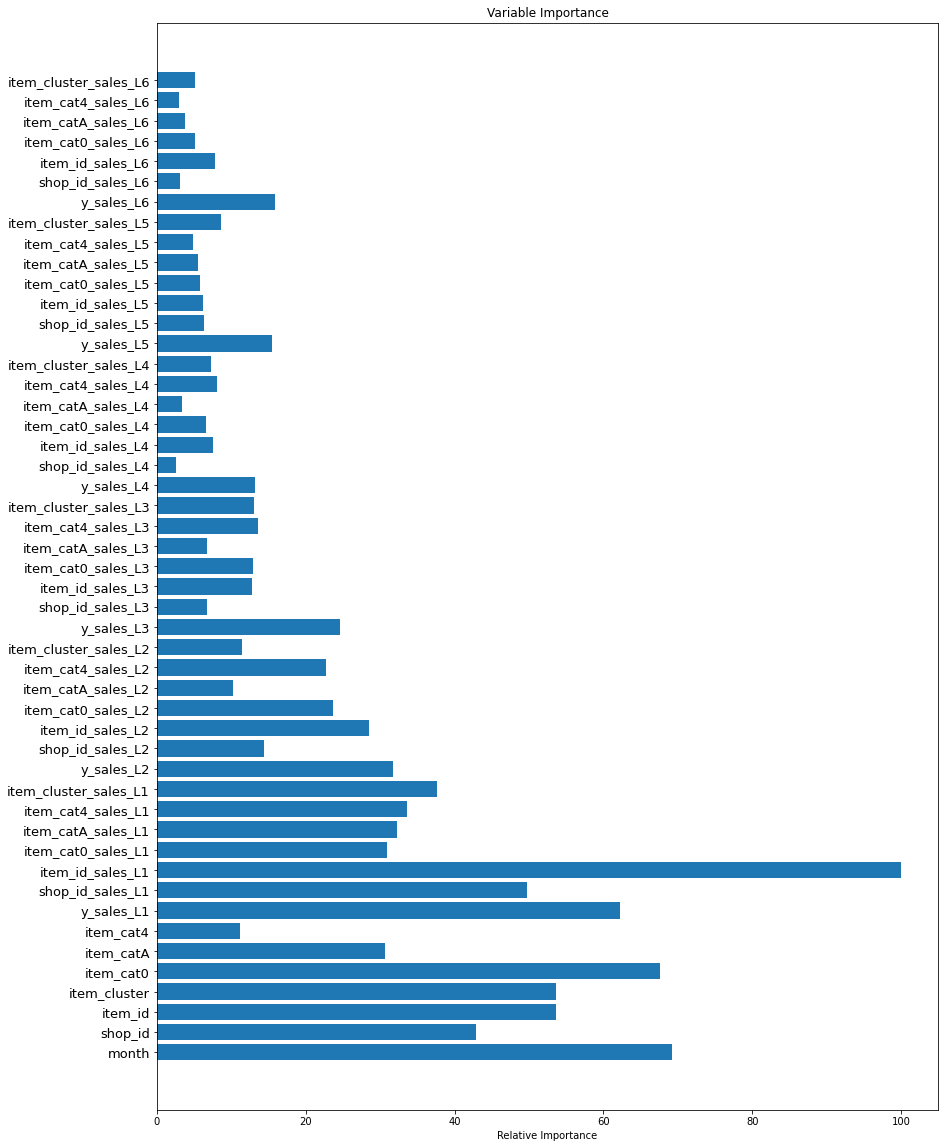

In [142]:
# Plot feature importance - Results Visualization
feature_importance = model_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.arange(feature_importance.shape[0])
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(14,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])  # ensemble_feature_names[-1]
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
# plt.savefig('LGBM_feature_importance_v1.4_mg.png')
plt.show()

#####Stop Execution / Record Results

In [ ]:
# Dummy cell to stop the execution so we don't run any of the random code below (if we select "Run All", e.g.)
b4 = b5

In [ ]:
Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers

LGBMv3mg_01:  Pre-train clip 0,20; CartProd/TrainStart= month 10; End=32; Val = month 33
    learning_rate=0.1,
    num_iterations=1000,
    early_stopping_round=50,
    feature_fraction=0.8,
Early stopping, best iteration is:
[121]	valid_0's rmse: 0.950043
R^2 train =  0.4789    R^2 val =  0.3032
RMSE train = 0.8829    RMSE val = 0.9500
Coursera 8/10 public and private LB scores are: 0.997392 and 0.999304

_02: no Pre-train clip (used sqrt compression earlier)
Early stopping, best iteration is:
[107]	valid_0's rmse: 1.37628
R^2 train =  0.2077    R^2 val =  0.1750
RMSE train = 2.5109    RMSE val = 2.1412
Coursera 5/10 public and private LB scores are: 1.008014 and 1.004042

_03: like _01 but pre-train clip at 0,18
Early stopping, best iteration is:
[171]	valid_0's rmse: 0.915338
R^2 train =  0.4927    R^2 val =  0.3079
RMSE train = 0.8446    RMSE val = 0.9153
Coursera 5/10 public and private LB scores are: 0.998724 and 1.000856

_04: like _01 but train 10-31, val 32-33
Early stopping, best iteration is:
[87]	valid_0's rmse: 0.938215
R^2 train =  0.4726    R^2 val =  0.3296
RMSE train = 0.8898    RMSE val = 0.9382
Coursera 5/10 public and private LB scores are: 1.000803 and 1.001518

_05: like _01 but train 24-32, val 33
Early stopping, best iteration is:
[122]	valid_0's rmse: 0.960556
R^2 train =  0.5164    R^2 val =  0.2878
RMSE train = 0.7662    RMSE val = 0.9605
Coursera 5/10 public and private LB scores are: 1.012674 and 1.014969

_06: like _01 but include lags of 1,2,3,6; CartProd/TrainStart= month 8; TrainEnd=32; Val = month 33
Early stopping, best iteration is:
[189]	valid_0's rmse: 0.93307
R^2 train =  0.4996    R^2 val =  0.3280
RMSE train = 0.8708    RMSE val = 0.9330
Coursera: 8/10 public and private LB scores are: 0.997198 and 0.998091

_07: like 06, but scale sales by 'week_retail_weight', and store sales as a float throughout (no downcasting = downcasting to float throughout)==> strange LGBM fitting behavior
Early stopping, best iteration is:
[4]	valid_0's rmse: 0.655184
R^2 train =  0.1618    R^2 val =  0.0691
RMSE train = 0.7422    RMSE val = 0.6552
Coursera: 3/10 public and private LB scores are: 1.170977 and 1.162842

_08: like 06, but no downcasting
Early stopping, best iteration is:
[189]	valid_0's rmse: 0.93307
R^2 train =  0.4996    R^2 val =  0.3280
RMSE train = 0.8708    RMSE val = 0.9330

#**Miscellaneous Code Snippets and Thoughts for Future Work**

In [ ]:
# # save predictions for an ensemble
# pickle.dump(y_pred_train, open("./models_and_predictions/" + model_name + '_pred_train.pickle', 'wb'))
# pickle.dump(y_pred_val, open("./models_and_predictions/" + model_name + '_pred_val.pickle', 'wb'))
# pickle.dump(y_pred_test, open("./models_and_predictions/" + model_name + '_pred_test.pickle', 'wb'))

# # save the model to disk
# pickle.dump(model, open("./models_and_predictions/" + model_name + '_model.sav', 'wb'))

 
# # load the model from disk
# loaded_model = pickle.load(open(model_file_name, 'rb'))

###**Force predictions = 0 for shops that have closed**

In [ ]:
'''
# It looks like the average prediction for items that haven't sold in the previous 6 months before month 34
#   is roughly 1647 / 23982 = 0.07
#
# Let's try setting these items' predictions to 0 and see if the grader is happy
'''

# Nope, this actually made things slightly worse per the coursera grader

'''
nosales = y_pr_test_mrg.loc[y_pr_test_mrg['item_id'].isin(items_6mo_in_test)]
print(len(nosales))
print(nosales.item_cnt_month.sum())
nosales['item_cnt_month'] = 0
y_pr_test_mrg = y_pr_test_mrg.merge(nosales[['shop_id','item_id','item_cnt_month']], on=['shop_id','item_id'], how='left').fillna(1)
print(len(y_pr_test_mrg))
print(y_pr_test_mrg.head())
y_pr_test_mrg['item_cnt_month'] = 0
y_pr_test_mrg = y_pr_test_mrg.eval('item_cnt_month = item_cnt_month_x * item_cnt_month_y')
print(len(y_pr_test_mrg))
print(y_pr_test_mrg.head())
nosales = y_pr_test_mrg.loc[y_pr_test_mrg['item_id'].isin(items_6mo_in_test)]
print(len(nosales))
print(nosales.item_cnt_month.sum())

y_submission = y_pr_test_mrg.drop(['shop_id','item_id','item_cnt_month_x','item_cnt_month_y'],axis=1)
print(len(y_submission))
print(y_submission.head())
'''
nocode=True

####Model-Specific Feature Set
* Recode Ordinal-Encoded Categorical Features for similar value ranges between the features, so they will have similar weight as inputs to the model
* However, StandardScaler will not remove the undesired "ordinality" of the category coding.  In future, we need to do something like mean encoding, one-hot encoding, or dense one-hot (embedded) encoding.

In [ ]:
#Remove categorical features unless encoded (e.g one-hot encoding) for basically any method other than a tree method (Linear Regresion, Neural Networks etc)
# from sklearn.preprocessing import StandardScaler
LinRegFeaturesToDrop= ['month', 'shop_id', 'item_id', 'item_cat0']
scaler =  StandardScaler()

X_train_LinReg = scaler.fit_transform(X_train.drop(LinRegFeaturesToDrop, axis = 1))
X_val_LinReg = scaler.transform(X_val.drop(LinRegFeaturesToDrop, axis = 1))
X_test_LinReg = scaler.transform(X_test.drop(LinRegFeaturesToDrop, axis = 1))
feature_names_LinReg = X_train.drop(LinRegFeaturesToDrop, axis = 1).columns

In [ ]:
feature_names = X_train.columns
X_train_np = X_train.to_numpy(dtype = np.float16)
del X_train
X_val_np = X_val.to_numpy(dtype = np.float16)
del X_val
X_test_np = X_test.to_numpy(dtype = np.float16)
del X_test
X_train_np.nbytes/(10**6)

638.256072

###**XGBoost - Gradient-Boosted Decision Tree**

In [ ]:
%%time
X_train_model, X_val_model, X_test_model = X_train_np, X_val_np, X_test_np

model = XGBRegressor()
model.fit(X_train_model, y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + 'R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + 'RMSE val_score is ' + str(val_rmse))

[21:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 train_score is 0.09796589353051244R^2 val_score is 0.06403915444253994
RMSE train_score is 8.607288197126733RMSE val_score is 10.750826813311914


####Feature Importance and Submission of Results for XGBoost

In [ ]:
# Plot feature importance - Results Visualization
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(14,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('gbt_feature_importance_mg.png')

Sumbission prep

In [ ]:
model_name = 'XGBv2'

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))

 
# # load the model from disk
# loaded_model = pickle.load(open(model_file_name, 'rb'))

###**To-Do List**

####1. **Test/Train Split**
* **Don't Shuffle for now** ... Time-series data generally benefits from being fed to model without shuffling (Andreas).</br>
Although, I'm curious about shuffling the training/val data rows, within a given month at least, and after split.  I definitely think the val data should come from the last xx months, where xx= 1 to 6, depending on size of dataset, and month range of truncated data set.
* **Possible Model Split or Additional Feature**... Consider sales variance by_year or by_2years (instead of by_month) for items with low price, vs. variance for items with high price... (or, low/high sales)... sales trends could be different enough that we might benefit from adding such a feature, or from training multiple models with training/val/test data split according to the focus of each model. </br> Based on the graphics of feature importance generated by Andreas, I'm not sure this is a big issue, but if I'm understanding correctly, the std is only calculated on a monthly grouping, and not on the entire sales_train set.  The std might be more important if mean or median of 6, 12, 18, or 24 months is made into a feature.


####2. **Weighting of shops and items based on recent behavior**
* **Explicit Forcing of Predictions = 0** for items or shops that have zero sales in the past 3, 6, or 12 months (as if the shop closed, or as if the item is no longer being sold).  Need to first check the months at 11, 12, 13 before the test month, to make sure shop opening, or item for sale is not a seasonal thing.
* **Weighting for shops based on integral of sales**... The thought is that Andreas' feature importance plot shows trend-based features to be of minor importance, so it may be more relevant to look at trend-based features where final month (or two or three) have zero sales vs. those that have trends without zero sales. (e.g., if zero sales for months 30-33, or if 500 sales for months 30-33, you have same trend, but would want to make very different predictions... so trend may be more relevant when combining with some knowledge about number of sales, like a feature = "trend x total sales."  (i.e., the integral of sales rather than the slope of sales).  This might be simply done with pandas' "rolling" method.


####3. **Feature Adjustment**
* **Re-Scale the Stats-Based Features**... perhaps not important for decision tree models, but other models will probably benefit by scaling everything to the same range (perhaps int16 or uint16). Or, scale to slightly different ranges, based on intuition of feature importance.  Sales by shop_item pair per month is likely more important than sales by item_cat3 per month, yet the latter is presently substantially larger than the former.
* **Better encoding for categorical features**... instead of a random-ordinal encoding or a pure ordinal encoding, we should reduce the influence of encoding on feature behavior. Consider mean-encoding or sklearn.feature_extraction.FeatureHasher or TensorFlow embedded categorization to keep number of features down? Could be more memory-friendly than one-hot encoding.
* **Workdays and Holidays per month** ... Adjust item_cnt_day by number of days in month block; also adjust for holidays and weekends, if it is clear there are no sales on such days.  Or, give different weight to sales on weekends or holidays if we see these dominate the sales vs. if they have very few sales. (Scale by number of weekends/holidays in each month vs. Nov. 2015).  Need to do further EDA first, to see if there really is a deviation of sales on these non-standard days, probably using original dataset grouped by shop_id.</br>
Also need to check on monthly behavior... months like December, January, and February may behave differently than other months because of Christmas and because of the large concentration of Russian holidays.  It could make sense to scale the sales of these months so they fit better the overall trends of sales from October to March.  In this way, we feed the model a better-behaved dataset that is not overly influenced by crazy months (particularly, since we are given November as test, and will validate on "smooth" months like October, or Sept+Oct, or Aug+Sept+Oct... and won't be doing any test/val on crazy months)


####4. **Data Memory Requirements and Model Training Time**
* **Expanding the Number of Rows in Test/Val**... Consider expansion of cartesian-product size and number of dataframe months being kept for test/val, if things are running quickly and without huge memory requirements.
* **More Categ. Features**... Consider expansion of the number of categorical generated features that are included.  I so far have only chosen a few, which I though matched with Andreas' output of feature importance.
* **More Stats Features**... Consider expansion of the number of stats features to be included.  I chose to use only the sum() aggregation function because it was simple to implement and understand, and matched well with Andreas' feature importance.  I could add in other stats like std, or (as described above) something like a rolling integral, or some other stat aggregation where instead of "by_month", it could be "by_3mo" or "by_season"
* **Interpolating Price for Cartesian-Product Rows**... Consider inclusion of price in the train/val/test data, where some sort of interpolation is used to fill the empty values after cartesian-product merge.  Maybe something simple like ffill or a fast algorithm.
* **Interpolating Sales for Cartesian-Product Rows**... Consider the case where sales_train doesn't represent *all* sales over that time period... some shop-item combinations may have nonzero sales, but were not included in the sales_train dataset for some reason.  (I don't think we were given any guarantees that sales_train was a complete representation of all sales.)  We may want to run training/val after cartesian-product merge, and see if it gives nonzero sales predictions for any of the newly-merged rows.  Then, we use these predictions, re-generate the features, and re-train the model.  Repeat as long as the model keeps getting better.  (This could also be a way to refine or interpolate for *price* if we choose to use it as a feature or feature generator.)



####Done:
* pd.cut or pd.qcut to reduce complexity of item price feature --> int16
* When grouping by month, use sum() for item_cnt_day, but use median() for other integer type features so the feature column will also be an integer (not sure if this is going to be strictly true, after watching how pandas behaves... I believe I saw one time where pandas gave the median as something like 100.5, to show that values 100 and 101 were equally centered in the data.  So instead of choosing one of these integer values, it may return a float.... I need to check if this can be set in the median() parameters, or if downcasting to an integer forces it to round the float properly vs. generating a crazy number or a NaN)
* Temporarily merge test rows into training data set before performing feature generation, so that where desirable, the feature generation is applied in a way that gives minimal "special treatment" to test or train sets.
* Convert data types and category encodings so as to use minimal memory (int8 or int16 better than int32, int64, float32, string).
* Similarly, focus on most important features (as determined from earlier modeling experiments by Andreas), and delete less-helpful columns to reduce memory requirements.
* Also, discard features (luckily mostly of secondary importance) that need to be stored with 4 or more bytes, as these features rapidly grow the dataset size.
* Be sure to reset_index(drop=True) as this can save many Megabytes if it had changed to the default int64. (I don't know yet exactly when pandas decides to do this... probably after something like a merge or group operation that can influence the index.  Anyhow... just be sure to reset the index when memory is of importance.)
* Keep dataset size down by judiciously choosing shops/items to use in cartesian-product when filling out the sparse sales_train data to better match the test set shop/item pairs.
* Keep number of lag features relatively small, and the number of months in the biggest lag to be reasonably small, so we can drop a significant number of early months from the training data.


###**Using Feathering to Save / Load Large Datafiles More Quickly**

In [ ]:

import feather   # this is 3x to 8x faster than pd.read_csv and pd.to_hdf, but file size is 2x hdf and 10x csv.gz

if not traintest_loaded:
    print(f'traintest dataframe creation started: {strftime("%a %X %x")}\n')
    traintest = clean_merge_augment()

    # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
    %cd "{OUT_OF_REPO_PATH}"
    traintest.to_feather('traintest.ftr')
    print("traintest.ftr feather file stored on google drive, outside repo")
    %cd "{GDRIVE_REPO_PATH}"
    # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
    compression_opts = dict(method='gzip',
                            archive_name='traintest.csv')  
    traintest.to_csv('data_output/traintest.csv.gz', index=False, compression=compression_opts)
    print("traintest.csv.gz file stored on google drive in data_output directory")
    print(f'traintest file save done: {strftime("%a %X %x")}')

display(traintest[traintest.week == 102].tail(2))


# Reading in the feather file:
#  Except for fast-loading (large filesize) feather format files, 
#   the data is coming from a public repo on GitHub at github.com/migai/Kag that has been synced to my local repo on Google Drive

'''
############################################################
############################################################
'''
# Replace this path with the path on *your* Google Drive where the repo master branch is stored
#   (on GitHub, the remote repo is located at github.com/migai/Kag --> below is my cloned repo location)
GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
OUT_OF_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final"   # place > 100MB files here, because they won't sync with GitHub

traintest_loaded = True   # set this to True if you plan to load the .ftr or the .csv.gz version of the traintest dataframe, and skip the calculations below that generated it
ftr_file_load_employed = True #False #True  # set to True if you wish to load the .ftr version or the .csv.gz version... it's faster, but its a 10x larger file, and won't work in the GitHub repo push


# if using large feather file for fast loading, use the routine here
#   note that this is too large to push to GitHub, so if you want to go this route, 
#   you'll first have to load (more slowly) the 'data_output/traintest.csv.gz' file 
#   with pandas read_csv, and then store the file as feather type (outside your local GitHub repo)
#   Or, you can just recreate the dataframe by running the first few code cells that do merging and data manipulation
# load feather files manually for now
if (traintest_loaded and ftr_file_load_employed):
    print('ftr files source directory: ', end='')
    %cd "{OUT_OF_REPO_PATH}"
    traintest = pd.read_feather('traintest.ftr', columns=None, use_threads=True)
    print("Loading ftr Files from Google Drive (outside repo) into Colab... \n\nData Frame: traintest (from ftr)")
    print(traintest.head(2))

'''
############################################################
############################################################
'''

,day,DoW,DoM,week,qtr,season,month,price,sales,shop_id,item_id,item_name,it_test,item_category_id,item_category_name,it_cat_test,item_cat3,item_cat4,shop_name,sh_cat,sh_test,district,city
2257039,718,Sat,20,102,8,1,23,399,1,59,21970,shar predictor soccer ball,False,69,Gifts - Souvenirs,True,Gifts,Gifts,"Yaroslavl shopping center ""Altair""",SEC,True,Central,Yaroslavl
2257040,718,Sat,20,102,8,1,23,499,1,59,22060,epic bluray dvd,True,37,Movie - Blu-Ray,True,Movies,Movies,"Yaroslavl shopping center ""Altair""",SEC,True,Central,Yaroslavl



traintest done: Tue 21:24:00 06/16/20


In [ ]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# data_gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks'
# os.chdir(data_gdrive_repo_path)

data_folder = 'models_and_predictions/'
filename = 'TS_Stats-Features-for-Modelling-v3_mg.feather'

In [ ]:
data = matrix[matrix['month'] >= 14]
data.reset_index().astype('float32').to_feather(data_folder + filename)

In [ ]:
data = pd.read_feather(data_folder + filename, columns=None, use_threads=True)
data = data.astype({'index': np.int32}).set_index('index')
cols_by_types = infer_variable_types(matrix)
data = sort_variable_types(data, categorical_cols = cols_by_types['categorical'], numerical_cols = cols_by_types['numerical'])
data.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_mean_by_item_lag_1,sales_mean_by_item_lag_2,sales_mean_by_item_lag_3,sales_mean_by_item_lag_6,sales_mean_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_mean_by_shop_lag_1,sales_mean_by_shop_lag_2,sales_mean_by_shop_lag_3,sales_mean_by_shop_lag_6,sales_mean_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_mean_by_item_category_lag_1,sales_mean_by_item_category_lag_2,sales_mean_by_item_category_lag_3,sales_mean_by_item_category_lag_6,sales_mean_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,trend_price_mean_by_item_lag_1,trend_price_mean_by_item_lag_3,trend_price_mean_by_item_lag_6,trend_price_mean_by_item_lag_12,trend_sales_mean_by_item_lag_1,trend_sales_mean_by_item_lag_3,trend_sales_mean_by_item_lag_6,trend_sales_mean_by_item_lag_12,trend_price_mean_by_shop_lag_1,trend_price_mean_by_shop_lag_3,trend_price_mean_by_shop_lag_6,trend_price_mean_by_shop_lag_12,trend_sales_mean_by_shop_lag_1,trend_sales_mean_by_shop_lag_3,trend_sales_mean_by_shop_lag_6,trend_sales_mean_by_shop_lag_12,trend_price_mean_by_item_category_lag_1,trend_price_mean_by_item_category_lag_3,trend_price_mean_by_item_category_lag_6,trend_price_mean_by_item_category_lag_12,trend_sales_mean_by_item_category_lag_1,trend_sales_mean_by_item_category_lag_3,trend_sales_mean_by_item_category_lag_6,trend_sales_mean_by_item_category_lag_12,above_12m_mean_price_mean_by_item,above_12m_mean_sales_mean_by_item,above_12m_mean_price_mean_by_shop,above_12m_mean_sales_mean_by_shop,above_12m_mean_price_mean_by_item_category,above_12m_mean_sales_mean_by_item_category
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11128045,34,46,12470,0.0,193773,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11128046,34,41,12470,0.0,198873,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11128047,34,44,12470,0.0,203973,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11128048,34,39,12470,0.0,209073,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11128049,34,45,12470,0.0,214173,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


### **Feature Generation/Engineering (Andreas' Early Work)**

Time series features
*   Statistics of previous months (e.g. mean of item_price for a specific item/shop in previous months)
*   Trends of previous months - rate of change of the above statistics based features (e.g. rate of change of mean item_price from today to the past 3 months for a specific shop/item)




####1.2) Statistics-Based Features -- Time Lag

> Lag them (put them in the same row/month as the one you'll be using them to predict - e.g e.g if going to use 6 month ago mean of item_price to predict item_cnt of next month, put 6 month ago mean of item_price in the same row as current month's values, used to predict next month)


In [ ]:
for i in range(len(Stats_features_second)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_second[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged

In [ ]:
for i in range(len(Stats_features_third)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_third[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged

fetures_to_drop = TS_features + Stats_features #features are renamed and added as a new column within the lag_features functions, so remove these one
matrix = matrix.drop(fetures_to_drop, axis = 1)
matrix = matrix.fillna(0)
matrix[matrix['month']==13].head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1
2293,13,2,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,1208.0,1730.0,1351.0,1063.0,1062.0,890.0,1322.0,862.0,875.0,488.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,1419.0,899.0,0.528809,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.072266,1.105469,119.0,0.0,119.0,1.0,1.0,0.0,1.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0
2294,13,3,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,936.0,1117.0,906.0,636.5,724.0,968.0,1134.0,970.0,890.0,798.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,1384.0,598.5,0.320557,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.057617,1.105469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0
2295,13,4,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,1060.0,1129.0,918.5,689.0,752.5,1430.0,2248.0,1486.0,1713.0,2025.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,2436.0,499.0,0.667480,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.120117,1.105469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0
2296,13,5,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,885.0,1025.0,821.5,580.0,591.5,1639.0,2224.0,1390.0,1510.0,877.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,1991.0,399.0,0.442139,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.099609,1.105469,149.0,0.0,149.0,3.0,1.0,0.0,1.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0
2297,13,6,32,0.0,0,40,144.75,148.0,144.375,340.25,337.75,84.0,89.0,81.0,72.0,208.0,998.0,971.0,790.5,657.0,703.0,3024.0,5468.0,3938.0,3702.0,4008.0,252.875,257.75,253.25,234.5,252.125,22064.0,28592.0,25440.0,24128.0,31648.0,16.890625,149.0,0.349365,1.0,2380.0,399.0,0.582031,1.0,121.0625,199.0,0.457764,1.0,1.105469,1.106445,1.105469,149.0,0.0,149.0,2.0,1.0,0.0,1.0,863.0,1703.0,399.0,116899.0,1.176758,1.15918,1.0


####2.1) Trend-Based Features

> Rate of change of Time series based features (mean of price or item count at past lags/months). Rates of change are calclulated for the past 1m, 3m, 6m, 12m



In [ ]:
ts = time.time()
trend_lags = [2, 
              #4, 7, 13
              ]
for TS_feature in TS_features:
  for i in trend_lags:
    matrix['trend_' + TS_feature + '_lag_'+str(i-1)] = \
        (matrix[TS_feature +'_lag_'+str(i)] - matrix[TS_feature + '_lag_1']) / matrix[TS_feature + '_lag_1']
print(time.time()-ts)
matrix.tail()



2.1509287357330322


,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1
11128045,34,46,12470,0.0,193773,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128046,34,41,12470,0.0,198873,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128047,34,44,12470,0.0,203973,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128048,34,39,12470,0.0,209073,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11128049,34,45,12470,0.0,214173,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


####3.0) Inspection of Data

Understanding dataframe created ("matrix")

In [ ]:
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_sum_by_item_lag_1,sales_sum_by_item_lag_2,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_2,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_sum_by_item_category_lag_1,sales_sum_by_item_category_lag_2,sales_sum_by_item_category_lag_3,sales_sum_by_item_category_lag_6,sales_sum_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_lag_1,sales_mean_by_shop_lag_1,sales_mean_by_item_category_lag_1,price_mean_by_item_and_shop_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,price_mean_by_month_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_sum_by_month_lag_1,sales_mean_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1
0,0,0,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_category_id', 'price_mean_by_item_lag_1',
       'price_mean_by_item_lag_2', 'price_mean_by_item_lag_3',
       'price_mean_by_item_lag_6', 'price_mean_by_item_lag_12',
       'sales_sum_by_item_lag_1', 'sales_sum_by_item_lag_2',
       'sales_sum_by_item_lag_3', 'sales_sum_by_item_lag_6',
       'sales_sum_by_item_lag_12', 'price_mean_by_shop_lag_1',
       'price_mean_by_shop_lag_2', 'price_mean_by_shop_lag_3',
       'price_mean_by_shop_lag_6', 'price_mean_by_shop_lag_12',
       'sales_sum_by_shop_lag_1', 'sales_sum_by_shop_lag_2',
       'sales_sum_by_shop_lag_3', 'sales_sum_by_shop_lag_6',
       'sales_sum_by_shop_lag_12', 'price_mean_by_item_category_lag_1',
       'price_mean_by_item_category_lag_2',
       'price_mean_by_item_category_lag_3',
       'price_mean_by_item_category_lag_6',
       'price_mean_by_item_category_lag_12',
       'sales_sum_by_item_category_lag_1', 'sales_sum_by_item_ca

In [ ]:
df = matrix
df1 = df.describe(include = 'all')

df1.loc['dtype'] = df.dtypes
df1.loc['size'] = len(df)
df1.loc['% count'] = df.isnull().mean()
df1.loc['%count 0'] = df.apply(lambda col: (col.count() - np.count_nonzero(col)))
df1

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id
count,1.11280e+07,1.11280e+07,1.11280e+07,1.11280e+07,1.11280e+07,1.11280e+07
mean,15.3396,31.196,11303.7,NaN,2061.52,44.9441
std,9.7604,17.3538,6210.93,0,17033.3,15.1401
min,0,0,0,0,0,0
25%,7,16,5947,0,0,37
50%,15,30,11388,0,0,40
75%,23,47,16592,0,0,55
max,34,59,22169,20,214199,83
dtype,int8,int8,int16,float16,int32,int64
size,11128050,11128050,11128050,11128050,11128050,11128050


In [ ]:
data = matrix

use_toy_data = False #to be used just for code to run quicker when tests are needed to be made
if use_toy_data == True:
  train_start_index = 26
else:
  train_start_index = 14 #skip first 13 months - used to caclulate time series features
train_final_index = 28 #makes validation set to be 20% of the non-test data (threshold is surely debatable)

data = data[data['month'] >= train_start_index]

X_train = data[data.month <= train_final_index].drop(['item_cnt_month', 'ID'], axis=1)
y_train = np.array(data[data.month <= train_final_index]['item_cnt_month'])

X_val = data[(data.month > train_final_index) & (data.month <= 33)].drop(['item_cnt_month', 'ID'], axis=1)
y_val = np.array(data[(data.month > train_final_index) & (data.month <= 33)]['item_cnt_month'])

X_test = data[data.month == 34].drop(['item_cnt_month', 'ID'], axis=1)
X_test = pd.merge(test, X_test, on= ['month', 'item_id', 'shop_id']).drop(['ID'], axis = 1) #to ensure consistency in rows with test sumbission file
del data

In [ ]:
#---------------------------Create Stats based features--------------------------------
#Stats based features = features computed based on stats of item price/cnt of shops or item for just the previous month

ts = time.time()
Stats_lags = [1]

Stats_features = [
                  'price_std_by_item', 'price_median_by_item',
                 'sales_std_by_item', 'sales_median_by_item',
                 'price_std_by_shop', 'price_median_by_shop',
                 'sales_std_by_shop', 'sales_median_by_shop',
                 'price_std_by_item_category', 'price_median_by_item_category',
                 'sales_std_by_item_category', 'sales_median_by_item_category',
                  'sales_mean_by_item', 'sales_mean_by_shop', 'sales_mean_by_item_category' ,
                  'price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',
                  'sales_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop',
                  'price_mean_by_month', 'price_std_by_month', 'price_median_by_month',
                  'sales_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month'
                ]
                                  
'''

'''
#Splitting Stats_features as below helped as a quick fix for the session getting crashed from running out of RAM (if GPU still crashes, use TPU for this one - has more RAM)
length = len(Stats_features)
index = length//3
Stats_features_first = Stats_features[:index]
Stats_features_second = Stats_features[index:(index*2)]
Stats_features_third = Stats_features[(index*2):]

for i in range(len(Stats_features_first)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_first[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['month','shop_id','item_id'], how='left')
del matrix_lagged


####4.0) Miscellaneous

In [ ]:
# Discarding price information for now, due to issues with filling cartesian product empty values
# # item price is overly descriptive, and requires a 4-byte storage per entry
# #  let's bin it down to just 127 categories, binned by quantiles, and store in int8 1-byte values
# #  Note: due to duplication of bin boundaries, need to set q=750 to get 200 categories (uint8); q=370 gives 127 categories (int8)

# # # 350 --> 117, 200 --> 83 ,  500-->153,  750-->200, 370-->127
# # nbins, labelrange = 370, 127
# # i_p_binned, i_p_boundaries = pd.qcut(stt.item_price,q=nbins,precision=0,duplicates='drop',retbins=True,labels=list(range(labelrange)))
# # bins_table = pd.DataFrame(zip(i_p_boundaries,list(range(labelrange))),columns=['Threshold','Label'])
# # ipbins=i_p_binned.value_counts()
# # bins_table['bin_counts'] = bins_table.Label.apply(lambda x: ipbins.loc[x] if x in ipbins.index else 0)
# # bar = bins_table.iloc[:][:].plot.bar(x='Threshold',y='bin_counts',figsize=(20,8))

# N_BINS = 370  # will return only 127 bins, due to data distribution causing bin overlap

# price_binned = pd.qcut(stt.price[stt.month < 34], q=N_BINS, precision=0, duplicates='drop', labels=False)
# testbins = pd.Series(np.zeros((TEST_LENGTH), dtype=np.int8))
# price_binned = price_binned.append(testbins, ignore_index=True)
# stt.price = price_binned.astype(np.int8)
# print(stt.head(2))
# print(stt.tail(2))

In [ ]:
# In future, this is some thinking on how one might interpolate prices into empty cartesian-product rows
# skip this; we are leaving out the "price" feature for now

# Compute 'price' feature for month=34 (test set) and any cartesian-product empties
#  use most recent monthly 'price' median for shop_item pair = month 34 shop-item pair
#  use monthly 'price' median by item if shop-item pair is not in months 0-33
#  use monthly 'price' median by shop_item_cluster if item is not in months 0-33
#  use monthly 'price' median by item_cluster if shop_item_cluster is not in months 0-33
#  use monthly 'price' median by shop_item_cat if item_cluster is not in months 0-33
#  use monthly 'price' median by item_cat

In [ ]:
# DESIRED_DTYPES = ['ID               int32   index value from test data set; drop before model training if desired (= 0 for all train data)',
#                   'month            int8	ordinal-encoded month # from start of train data',
#                   'shop_id	        int8	categorical range(60) original shop_id values, minus 0,1,9,11,13',
#                   'item_id	        int16	categorical range(22170) original item_id values, 21671 present in sales_train_cln_mrg',
#                   'price	        int8	continuous (binned) variable, downcast from float64; price is in range (0 to 59200]',
#                   'item_cnt_day     int8   continuous variable, items sold that day at that shop, after clipping to 120 or some other desired value',
#                   'sales            int8   continuous variable, items sold that day at that shop, after clipping to 120 or some other desired value',
#                   'item_cnt_month	int16	continuous variable, items sold during the month at that shop, max value = 120 * 31days = int16; clip to 20 after model transform is applied',
#                   'sales_month  	int16	continuous variable, items sold during the month at that shop, max value = 120 * 31days = int16; clip to 20 after model transform is applied',
#                   'shop_typeA	    int8	Categorical feature indicating small shop / mall / SEC / online...',
#                   'shop_typeB	int8	Categorical feature like shop_typeA_enc, but merging together mall/Mega/SEC so fewer categories',
#                   'item_cat0	int8	Original category codes for the items (0 to 83)',
#                   'item_catA	    int8	reduction of original 84 categories, grouping primarily by item type',
#                   'item_cat3	    int8	reduction of original 84 categories, grouping primarily by item brand',
#                   'item_cluster	    int16	Categorical grouping of items by name similarity; encoding weighted',
#                   'item_test	    int8	True(=1) if item id is in the test set',
#                   'shop_test	    int8	True(=1) if shop id is in the test set',
#                   'shop_item_test	int8	True(=1) if shop-item pair is in the test set',
#                   'fd_popdens_enc	int8	Categorical feature indicating population density of the federal district the shop is in',
#                   'fd_gdp_enc	    int8	Categorical feature indicating gdp/person for the federal district the shop is in',
#                   'shop_city_enc	int8	Categorical feature indicating which city hosts the shop',
#                   'shop_federal_district_enc	int8	Categorical feature indicating which federal district the shop is in',
#                   'price_med_by_item            int8',
#                   'sales_by_item                int16',
#                   'price_med_by_shop            int8',
#                   'sales_by_shop                int16',
#                   'price_med_by_item_cat        int8',
#                   'sales_by_item_cat            int16',
#                   'price_med_by_shop_item       int8',
#                   'sales_by_shop_item           int16']

# def reset_dtypes(df, dtype_list=DESIRED_DTYPES):
#     """
#     function used to set the columns of dataframe df to the dtypes desired,
#     as given by list of strings where the first two whitespace-separated string
#     elements are the column name and the desired np dtype (not including np)
#     example: dtype_list = ['shop_id int8 some random descriptive text if you want', 'item_id int16 blah blah']
#     This gives you finer control over setting column dtypes as you would like, and
#     easily choosing which columns to perform this on.
#     Drawbacks of using this function: you need to create the dtype_list, and this function does no 
#     error checking to see if your desired dtype is inconsistent with column values (e.g., if you desire int8,
#     but your data actually exceeds +128, you could end up with a negative number during the type conversion.
#     The built-in pandas function seems to do a good job of checking so you don't underspecify the dtype.)
#     """
#     for i in dtype_list:
#         wds = re.findall(r"[\w]+", i)
#         if wds[1] != ('bool' | 'str' | 'object'): 
#             wds[1] = 'np.' + wds[1]  # prepend numerical datatypes with 'np.' (not comprehensive; only ignores bool, str, object dtypes)
#         if wds[0] in df.columns:
#             df[wds[0]] = df[wds[0]].astype(eval(wds[1]))
#     return df
# stt = reset_dtypes(stt)

# Alternative: instead of manually checking and setting dtypes, pandas function seems to work pretty well; unsigned, signed, integer, float...
#  see:  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html#pandas.to_numeric
# stt = stt.apply(pd.to_numeric, downcast='integer')
# print_col_info(stt,5)

In [ ]:
%%time
# starter DF (for merging with stats by month for broader category groupings)
#    monthly_stt = stt with shop-item pair item_cnt_day summed and grouped by month
#    (i.e., rows are the smallest divisions of the dataset by month, as we use the most specific shop and item "categories")
#  use median to keep integers as integers

monthly_stt = stt.groupby(['month','shop_id','item_id']).agg({  'shop_typeA':['median'], 
                                                                'shop_typeB':['median'], 
                                                                'item_cat0':['median'], 
                                                                'item_catA':['median'], 
                                                                'item_cat3':['median'], 
                                                                'item_cluster':['median'], 
                                                                'shop_test':['median'], 
                                                                'item_test':['median'], 
                                                                'shop_item_test':['median'],
                                                                'sales':['sum']
                                                                }).reset_index()
monthly_stt.columns = monthly_stt.columns.droplevel(1)
monthly_stt.rename({'sales':'sales_by_shop_item'}, axis='columns', inplace=True)

monthly_stt.sales_by_shop_item = monthly_stt.sales_by_shop_item.clip(0,255) # clip the sales/month aggregate sum to uint8

MONTHLY_STT_LENGTH = len(monthly_stt)

print(f'\nmonthly_stt dataframe total memory usage before downcast: {monthly_stt.memory_usage(deep=True).sum()/1e6:.0f} MBytes\n')
#Downcast
monthly_stt = monthly_stt.apply(pd.to_numeric, downcast='unsigned') #'integer')
print('monthly_stt dataframe memory usage after downcast:')
print_col_info(monthly_stt,6)
print(f'\n{monthly_stt.head(3)}')


monthly_stt dataframe total memory usage before downcast: 65 MBytes

monthly_stt dataframe memory usage after downcast:
  Column Name     DType MBytes                 Column Name     DType MBytes       
        Index     int64    0.0                   item_cat3     uint8    1.8       
        month     uint8    1.8                   item_cat4     uint8    1.8       
      shop_id     uint8    1.8                item_cluster    uint16    3.6       
      item_id    uint16    3.6                   shop_test     uint8    1.8       
   shop_typeA     uint8    1.8                   item_test     uint8    1.8       
   shop_typeB     uint8    1.8              shop_item_test     uint8    1.8       
    item_cat0     uint8    1.8          sales_by_shop_item     uint8    1.8       

Number of rows in DataFrame: 1,809,624
DataFrame total memory usage: 27 MB

   month  shop_id  item_id  shop_typeA  shop_typeB  item_cat0  item_cat3  item_cat4  item_cluster  shop_test  item_test  shop_item_test  s

In [ ]:
# Create artificial features as combinations of the above, to favor those items / shops in the test set
# by_shop_L1*shop_test, by_item_L1*item_test, by_shop_item_L1*shop_item_test
#   Let's assume we are going to train the model using month=33 as the validation set
#      and, we'll make a second training run using months 32 and 33 as the validation set
#   So, we need shop_test = 1 if shop in month=33.unique (and item_test, and shop_item_test)
#      and, another column if shop in months 32,33 (and item and shop_item)
shop_33_u = dfL.query("(month == 33) & (shop_test == 1)").shop_id.unique()
item_33_u = dfL.query("(month == 33) & (item_test == 1)").item_id.unique()
shop_3233_u = dfL.query("((month == 33) | (month == 32)) & (shop_test == 1)").shop_id.unique()
item_3233_u = dfL.query("((month == 33) | (month == 32)) & (item_test == 1)").item_id.unique()
dfL['s_i_pair'] = zip(dfL.shop_id.to_list(), dfL.item_id.to_list())
pair_33_u = dfL.query("(month == 33) & (shop_item_test == 1)").s_i_pair.unique()
pair_3233_u = dfL.query("((month == 33) | (month == 32)) & (shop_item_test == 1)").s_i_pair.unique()


# @numba.vectorize
# def multiply_columns_by_2(x):  # noqa E501
#     return x * 2

# dfL['shop_x_test_L1'] = dfL.eval('sales_by_shop_L1 * shop_test if shop_id in @shop_33_u else 0')
# dfL['item_x_test_L1'] = dfL.eval('sales_by_item_L1 * item_test if item_id in @item_33_u else 0')
# dfL['shop_item_x_test_L1'] = dfL.eval('sales_by_shop_item_L1 * shop_item_test if s_i_pair in @pair_33_u else 0')
# dfL['shop_x_test_L1L2'] = dfL.eval('(sales_by_shop_L1 + sales_by_shop_L2) * shop_test if shop_id in @shop_3233_u else 0')
# dfL['item_x_test_L1L2'] = dfL.eval('(sales_by_item_L1 + sales_by_item_L2) * item_test if item_id in @item_3233_u else 0')
# dfL['shop_item_x_test_L1L2'] = dfL.eval('(sales_by_shop_item_L1 + sales_by_shop_item_L2) * shop_item_test if s_i_pair in @pair_3233_u else 0')


dfL['shop_x_test_L1'] = dfL.sales_by_shop_L1
print(dfL.shop_x_test_L1.sum())
dfL.shop_x_test_L1 = dfL.query("shop_id not in @shop_33_u").shop_x_test_L1.apply(lambda x: 0) # = 0 #dfL.sales_by_shop_L1 #dfL.apply(lambda x: x.sales_by_shop_L1 * x.shop_test if shop_id in @shop_33_u else 0')
print(dfL.shop_x_test_L1.sum())
# dfL['item_x_test_L1'] = dfL.eval('sales_by_item_L1 * item_test if item_id in @item_33_u else 0')
# dfL['shop_item_x_test_L1'] = dfL.eval('sales_by_shop_item_L1 * shop_item_test if s_i_pair in @pair_33_u else 0')
# dfL['shop_x_test_L1L2'] = dfL.eval('(sales_by_shop_L1 + sales_by_shop_L2) * shop_test if shop_id in @shop_3233_u else 0')
# dfL['item_x_test_L1L2'] = dfL.eval('(sales_by_item_L1 + sales_by_item_L2) * item_test if item_id in @item_3233_u else 0')
# dfL['shop_item_x_test_L1L2'] = dfL.eval('(sales_by_shop_item_L1 + sales_by_shop_item_L2) * shop_item_test if s_i_pair in @pair_3233_u else 0')

dfL.s_i_pair = dfL.s_i_pair.astype('category')
dfL.s_i_pair = dfL.s_i_pair.cat.codes
dfL = dfL.apply(pd.to_numeric, downcast='integer')
print('Cartesian-product with lagged and combined features dfL (after downcast):')
print_col_info(dfL,8)
print(f'\ndfL.head:\n{df.head()}')

NameError: ignored

###Encoding categoricals

In [ ]:
'''
think about this later... probably want to do something like sqrt() on shop_sales and item_cat0_sales
but log() or sqrt(log) of x+1 => log1p() for item_sales and item_cluster_sales
and no expansion/compression for catA or cat3 sales...

%%time
# Scale the values of the different columns so they have similar (or properly weighted, based on importance) value magnitudes
#  Note, y_sales (= prediction target) is about 10x (or more) less than the grouped category sales

# I don't want to apply any additive or multiplicative transformation to y_sales, as this is directly related to what we want to predict
#  However, what I can do is clip it to some value sufficiently higher than the final clipping value of 20
#  Let's clip to ITEM_CNT_TRAIN_CLIP = 250 , as this fits into a uint8
# Then let's do histogram-like binning to force the various group-by-xx stats features into the same storage range, so all stats features will be in range(0,250)
#  --> the binning will cause loss of some information, but it will keep roughly the same relative spacing between the different categories
pred_target_colname = stats_col_names[0]  # put this in a variable name in case we change 'y_sales' to something different in the future
bin_cols = stats_col_names.copy()
bin_cols.remove(pred_target_colname)
monthly_stt2 = monthly_stt.copy(deep=True) # don't mess up monthly_stt while I'm developing this code
monthly_stt2[pred_target_colname] = monthly_stt2[pred_target_colname].clip(0,ITEM_CNT_TRAIN_CLIP)

before_bin_zero_item_sales = len(monthly_stt2[monthly_stt2.item_sales ==0])
#nps= np.vectorize(np.sqrt)  # np.sqrt(x/scale1) = 30s
for bc in bin_cols:
    #scale1 = monthly_stt2[bc].max() / 2000  # scale all columns to similar range before applying expansion to highlight lower values of sales
    #monthly_stt2[bc] = monthly_stt2[bc].apply(lambda x: np.sqrt(np.log1p(x)/scale1))    #np.log(np.sqrt(x)+1)) #(lambda x: np.log1p(x))  # compress the entries with huge numbers, so the linear scaling before binning keeps the finer info of small, but nonzero, values
    scale2 = monthly_stt2[bc].max() / ITEM_CNT_TRAIN_CLIP
    monthly_stt2[bc] = monthly_stt2[bc].apply(lambda x: 1+x/scale2 if x>0 else 0)  # add in the +1 and special case for 0, so we don't lose fractional stuff
    monthly_stt2[bc] = pd.cut(monthly_stt2[bc],ITEM_CNT_TRAIN_CLIP+1, precision=0, duplicates='drop', labels=False) #, include_lowest=True)

after_bin_zero_item_sales = len(monthly_stt2[monthly_stt2.item_sales ==0])

print(monthly_stt2.head())
print('\n')
print(monthly_stt2.describe())
print('\n')
print(f'Before binning, n_rows with item_sales == 0: {before_bin_zero_item_sales:,d}, and after binning: {after_bin_zero_item_sales:,d}')
print('\n')
# pandas describe(include='all') function has poor handling of numerical values when computing nunique for a column; however, using explicit nunique() works OK, so here's the following table:
co = 'Column Name'
nu = 'N Unique Values'
mx = 'Maximum Value'
mn = 'Minimum Value'
print(f'{co:>19}  {nu:>16}  {mx:>14}  {mn:>14}')
for c in monthly_stt2.columns:
    nu = monthly_stt2[c].nunique()
    mx = monthly_stt2[c].max()
    mn = monthly_stt2[c].min()
    print(f'{c:>19}  {nu:16d}  {mx:14d}  {mn:14d}')

'''
nocode=True

In [ ]:
'''
this ties in with the above code cell
ignore for now

# Demonstration of binning giving results quite similar to the (linearly scaled) original

# Also, interesting plots for each different shop's sales by month... several shops have no recent sales
# cat0, shop, item, itemcluster
pltcol = 'item_cluster'
cliptop = 100250
plotcolmincounts = 0
month = 20 # (and up)
monthly_stt3 = monthly_stt.copy(deep=True)
# monthly_stt3['shop_sales_scaled'] = monthly_stt3['shop_sales'] / (16338/250)
# monthly_stt3 = monthly_stt3.groupby(['month','shop_id']).agg({'shop_sales_scaled':['median'],'shop_sales_bin':['median']})
# # monthly_stt3.columns = ['shop_sales_scaled','shop_sales_bin']
# monthly_stt3 = monthly_stt3.groupby(['month','shop_id']).agg({'shop_sales':['median']})
# monthly_stt3.columns = ['shop_sales']
# monthly_stt3 = monthly_stt3.reset_index()
# print(monthly_stt3.head())
# for s in monthly_stt3.shop_id.unique()[20:25]:
#     dfplot = monthly_stt3[monthly_stt3.shop_id == s]
#     ax = dfplot.plot(x='month',y='shop_sales',kind='line',color='orange',figsize=(20,5),grid=True)
#     #ax2 = dfplot.plot(x='month',y='shop_sales_bin',kind='scatter',color='black',ax=ax)


monthly_stt3 = monthly_stt3.groupby(['month','item_id']).agg({pltcol:['median']})
monthly_stt3.columns = [pltcol]
monthly_stt3 = monthly_stt3.reset_index()
dfplot = monthly_stt3[monthly_stt3.month >= month].copy(deep=True)
print(dfplot.head())
dfplot[pltcol] = dfplot[dfplot[pltcol] >= plotcolmincounts][pltcol].clip(0,cliptop)
ax = dfplot.plot(x='month',y=pltcol,kind='hist',bins= 50,color='orange',figsize=(20,8),grid=True)
    
# for i in monthly_stt3.item_id.unique()[2000:2005]:
#     dfplot = monthly_stt3[monthly_stt3.item_id == i]
#     ax = dfplot.plot(x='month',y='item_sales',kind='line',color='orange',figsize=(20,10),grid=True)
#     #ax2 = dfplot.plot(x='month',y='shop_sales_bin',kind='scatter',color='black',ax=ax)

'''
nocode=True

In [ ]:
'''
# go back to using monthly_stt, because all of the following code uses that name, and I don't want to change all of it

monthly_stt = monthly_stt2.copy(deep=True)
'''
nocode=True

##**Determine the Strategy for Adding Cartesian Product Rows**

###Cartesian-Product Thoughts
It benefits us to expand the train/val data with additional rows corresponding to certain missing shop-item pairs, so our model has a better chance of accurately predicting for the shop-item pairs test set. This is primarily because categorical groupings give certain shop-item pairs relevance even if they are not in the train or test sets. </br>

* Because we have shops and items categorically grouped, we can infer certain things about a previously-unseen shop-item pair, by using the behavior of the shops and items in the same categories.
* To train in anticipation of being able to predict all test set shop-item pairs, the model needs to be scored on a train dataset that has all of the test set's shop-item pairs in each time period, with proper estimates of values that may need to be interpolated.  
** If we make the simplest assumption of zero sales for any shop-item pair not present in the sales_train dataset, we can just fill with 0 for any of the sales_by columns for the new cartesian product rows.
** If we use 'price' or one of its functional aggregates as a feature, things get more complicated, as it probably is not ideal to set price = 0 when adding the new cartesian product rows.  We need to infer or interpolate if we plan to use price-based features in our model.
** An alternative to manually interpolating is to train a preliminary model for months \< 34, and use the preliminary model(s) to make predictions for what sales counts should be used for the new cartesian product rows.  You might have one model for every aggregate feature, for example, or you could combine several of these features as "target" predictions in a single model.
* Similarly, it is important for the validation set to be scored based on predictions for all relevant shop-item pairs, and not just the shop-item pairs present in the sales_train dataset.
* We do not need to add cartesian product rows to month 34, because the model only considers single row inputs, and not chunks of rows as inputs. (Although this is a possible model variant... feeding it a group of correlated rows that are not already correlated by aggregate features... then the model has nrows times as many "feature inputs" to deal with)

</br>

What makes a shop-item pair relevant to add using cartesian product?:
* Shop focus:
* 1. Any and all shop_ids in the test set should be present in the train and validation sets</br>

</br>

* Item focus:
* 2. Any and all item_ids in the test set should be present in the train and validation sets
* 3. Any items that have the same item_category_id as any of the items in the test set
* 4. Any items that have the same item_cluster as any of the items in the test set</br>

</br>

* Date focus:
* 5. Recent months appear to be much more valuable than early months
* 6. Look for shops or items with zero sales in the future and also zero sales in the past xx months, and assume they are closed or no longer selling.  Set up some method of forcing the model prediction to be zero for the following month.

</br>

The cartesian product is going to create a huge number of extra rows, and will dramatically increase memory requirements and running time.  So, we need to be judicious in our choice of what months to expand in cartesian-land, and if any months should be dropped or can somehow manage without full cartesian product expansion.

####Inspect data to find a memory-friendly way of incorporating cartesian product rows

In [ ]:
# Populate the train/test dataframe with cartesian products to inform the model explicitly on behavior of shop-item pairs in previous months

# First, consider the following:
#  to help keep the dataframe memory requirements lower, let's only cartesian product rows for the most important features:
#  shop_id present in test, or item_id present in test, or item_cat0 present in test, or item_cluster present in test

test_shops_u = test_augmented.shop_id.unique()
test_items_u = test_augmented.item_id.unique()
test_item_cat_u = test_augmented.item_cat0.unique()
test_item_cluster_u = test_augmented.item_cluster.unique()
print(f'Unique test... shops = {len(test_shops_u)}, items = {len(test_items_u)}, item_cat0s = {len(test_item_cat_u)}, item_clusters = {len(test_item_cluster_u)}')

Unique test... shops = 42, items = 5100, item_cat0s = 62, item_clusters = 1218


In [ ]:
# See how many rows conform to either shop_id in test, item_id in test, item_cat0 in test, or item_clusters in test
# reduced_data = sales_train_test.query("(shop_id in @test_shops_u) | (item_id in @test_items_u) | (item_cat0 in @test_item_cat_u) | (item_cluster in @test_item_cluster_u)")
# print(f'Number of rows in reduced_data month 34 = {len(reduced_data[reduced_data.date_block_num == 34]):,d} (note, number of rows in test data set = {TEST_LENGTH:,d})')
# print(f'Unique reduced_data... shops = {reduced_data.shop_id.nunique()}, items = {reduced_data.item_id.nunique()}, item_cat0s = {reduced_data.item_cat0.nunique()}, item_clusters = {reduced_data.item_cluster.nunique()}')
# print(f'Number of rows in reduced_data: {len(reduced_data):,d}')
# not really worth it to filter down train data to just those that are closely related to test

# let's see what happens if we only consider as useful the shops / items / item_cats / item_clusters in months 20 to 34
CART_FILL_MO_START = CARTESIAN_FILL_MONTH_START # fixed value set above, just after loading data files (presently = 10)
CART_CORR_MO_START = CARTESIAN_CORRELATION_START_MONTH # (present value = 23)

nrows_stt = len(stt)
stt_month34_nrows = len(stt[stt.month == 34])

def find_correlated_shops_items(start_month = CART_CORR_MO_START, end_month = 34,
                                querystr = "(shop_id in @test_shops_u) | (item_id in @test_items_u) | (item_cat0 in @test_item_cat_u) | (item_cluster in @test_item_cluster_u)"):
    """
    The idea behind this function is to reduce computer memory requirements by reducing the number of shops and items from which we create our cartesian product...
        Instead of taking all unique shops (60) and items (22700) and applying them to form the rows present for every month in our train/val data,
        we only take the shops and items that have presence in a certain month range in the sales_train_test dataset,
        and, only take those that are closely correlated to test rows 
        (e.g. rows in sales_train_test that have the same shop_id as any of the test shops, or that have the same item_id, or same item_cat0, or same item_cluster code)
    Note that using intuition suggesting more-recent months will give more valuable information, we can limit the queried months in sales_train_test by adjusting start_month and/or end_month
        this will further reduce the numbers of "test-correlated" shop_ids and item_ids, to a point where our cartesian product size may be less than half that of the full version
    returns: dict with info on the sales_train_test rows matching query conditions, along with lists and list_lengths of the unique shops and unique items found by the query
    """
    reduced_dataframe = stt.query("(month >= @start_month) & (month <= @end_month)").query(querystr)
    cp = {}  # cartesian product info is held in this dict
    cp['shop_id_list'] = reduced_dataframe.shop_id.unique()
    cp['n_shop_ids'] = len(cp['shop_id_list'])
    cp['item_id_list'] = reduced_dataframe.item_id.unique()
    cp['n_item_ids'] = len(cp['item_id_list'])
    cp['item_cat0_list'] = reduced_dataframe.item_cat0.unique()
    cp['n_item_cat0s'] = len(cp['item_cat0_list'])
    cp['item_cluster_list'] = reduced_dataframe.item_cluster.unique()
    cp['n_item_clusters'] = len(cp['item_cluster_list'])
    cp['start_month'] = start_month
    cp['end_month'] = end_month
    cp['query_conditions'] = [x.split(" ")[0] for x in querystr.split("(")][1:]
    return cp

In [ ]:
%%time

cart_prod = find_correlated_shops_items()

# all test items are in the cartesian product, if we include month 34 when doing our query
# let's see how many of the shops and items are covered if we don't include month 34
# (this gives us an idea of how many of the test items (or their correlated categories) are not present in sales_train, and thus
#  an idea of how many of the cartesian product rows will have no original training information to interpolate values from)
# (note: when # uncovered shops = 0, then total number of test rows not present in cartesian product = 42 shops * n_uncovered_items)
for start_month in [15,17,19,21,23,25,27,29,CART_CORR_MO_START]:
    cart_prod_33 = find_correlated_shops_items(start_month, end_month=33)
    n_uncovered_test_shops33 = len(test_shops_u) - len([x for x in test_shops_u if x in cart_prod_33['shop_id_list']])
    n_uncovered_test_items33 = len(test_items_u) - len([x for x in test_items_u if x in cart_prod_33['item_id_list']])
    n_uncovered_test_item_cat0s33 = len(test_item_cat_u) - len([x for x in test_item_cat_u if x in cart_prod_33['item_cat0_list']])
    n_uncovered_test_item_clusters33 = len(test_item_cluster_u) - len([x for x in test_item_cluster_u if x in cart_prod_33['item_cluster_list']])
    print(f'\nFor query terms {cart_prod_33["query_conditions"]}, for {cart_prod_33["start_month"]:2d} <= month <= {cart_prod_33["end_month"]:2d}:',end='')
    print(f' n cartesian product rows = {cart_prod_33["n_shop_ids"]:2d} x {cart_prod_33["n_item_ids"]:<5d} = {(cart_prod_33["n_shop_ids"] * cart_prod_33["n_item_ids"]):,d}')
    print(f'    test_missing: shops = {n_uncovered_test_shops33:2d} / {len(test_shops_u):2d}, items = {n_uncovered_test_items33:>3d} / {len(test_items_u):4d}, ',end='')
    print(f'item_category_ids = {n_uncovered_test_item_cat0s33:1d} / {len(test_item_cat_u):2d}, item_clusters ={n_uncovered_test_item_clusters33:3d} / {len(test_item_cluster_u):4d}',end='')
    if n_uncovered_test_shops33 == 0:
        print(f', n test rows = {n_uncovered_test_items33:>4d} x {len(test_shops_u):2d} = {(len(test_shops_u)*n_uncovered_test_items33):,d} / {(len(test_shops_u)*len(test_items_u)):,d}')
    else:
        print('')
    

stt_rows_by_month = {}
stt_rows_in_cp = {}
cp_rows_in_stt = {}
cp_rows_not_in_stt = {}
total_rows_after_cp_merge = {}
stt_rolling_totals_before_cp_merge = {0:0}
stt_rolling_totals_after_cp_merge = {0:0}
cpshops = cart_prod['shop_id_list']
cpitems = cart_prod['item_id_list']
n_cptuples = cart_prod['n_shop_ids'] * cart_prod['n_item_ids']
print("\nComputation completed for month:",end='')
for m in range(35):
    stt_rows_by_month[m] = len(stt[stt.month == m])
    m_stt_in_cp = stt[stt.month == m].query("(shop_id in @cpshops) & (item_id in @cpitems)")
    stt_rows_in_cp[m] = len(m_stt_in_cp)
    m_unique_shop_item_pairs_in_STTandCP = set(m_stt_in_cp.apply(lambda row: (row.shop_id, row.item_id), axis = 1).to_list())
    cp_rows_in_stt[m] = len(m_unique_shop_item_pairs_in_STTandCP)
    cp_rows_not_in_stt[m] = (n_cptuples - cp_rows_in_stt[m]) * (m < 34)  # we won't be merging cartesian product into month 34
    total_rows_after_cp_merge[m] = stt_rows_in_cp[m] + cp_rows_not_in_stt[m]
    stt_rolling_totals_before_cp_merge[m+1] = stt_rolling_totals_before_cp_merge[m] + stt_rows_by_month[m]
    stt_rolling_totals_after_cp_merge[m+1] = stt_rolling_totals_after_cp_merge[m] + total_rows_after_cp_merge[m]
    print(f' {m},',end='')
print(' done')


For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 15 <= month <= 33: n cartesian product rows = 52 x 15545 = 808,340
    test_missing: shops =  0 / 42, items = 393 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  393 x 42 = 16,506 / 214,200

For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 17 <= month <= 33: n cartesian product rows = 52 x 14628 = 760,656
    test_missing: shops =  0 / 42, items = 405 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  405 x 42 = 17,010 / 214,200

For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 19 <= month <= 33: n cartesian product rows = 52 x 13472 = 700,544
    test_missing: shops =  0 / 42, items = 430 / 5100, item_category_ids = 1 / 62, item_clusters =  9 / 1218, n test rows =  430 x 42 = 18,060 / 214,200

For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 21 <= month <= 33: n cartesian product rows 

####As seen above, we only reduce the cartesian product size significantly if we restrict ourselves to selecting only recent-month attributes to evaluate for correlation with test shops and items.  I'm going to choose months 23-34 for determining what shops and items will make up the cartesian product.  It seems like a good range of months for compromise between size of eventual dataset and the number of test items that match with a correlated feature present in the original sales_train dataset.

In [ ]:
# compute aggregate values
total_additional_rows = sum(cp_rows_not_in_stt.values())
total_additional_rows_from_fillstart = sum(dict((key, cp_rows_not_in_stt[key]) for key in range(CART_FILL_MO_START,35)).values())
total_pre_merge_rows_from_fillstart = sum(dict((key, stt_rows_by_month[key]) for key in range(CART_FILL_MO_START,35)).values())
total_post_merge_rows_from_fillstart = sum(dict((key, total_rows_after_cp_merge[key]) for key in range(CART_FILL_MO_START,35)).values())
all_months_post_merge_rows = sum(total_rows_after_cp_merge.values())
merged_size_vs_start_month = dict((key, all_months_post_merge_rows - stt_rolling_totals_after_cp_merge[key]) for key in stt_rolling_totals_after_cp_merge)
# additional_rows_by_month = dict(sorted(cp_rows_not_in_stt.items()))  # if we want a nicely-sorted dict to just print the whole thing

In [ ]:
def colprintdict(m_start,stt_rows,stt_rows_in_cp,cp_rows_in_stt,cp_rows_not_in_stt,total_rows_stt_cp_merge,stt_before_m,merged_before_m,merged_nrows_ge_m):
    idx_names = ['month:','stt (k)','stt in cp (k)','cp in stt (k)','cp not in stt (k)',
                 'stt&cp (k)','stt lt.m (k)','stt&cp lt.m (k)','stt&cp ge.m (k)']
    idx_width = len(max(idx_names, key = len))
    numbers = [list(range(35)),stt_rows,stt_rows_in_cp,cp_rows_in_stt,cp_rows_not_in_stt,total_rows_stt_cp_merge,stt_before_m,merged_before_m,merged_nrows_ge_m]
    col_width = 6
    for rowdx in range(len(idx_names)):
        print_row = f'  {idx_names[rowdx]:>{idx_width}}'
        for i in range(m_start,35):
            div = 999 * (rowdx>0) + 1  # convert everything except month number to thousands, for tighter printing
            print_row += f'  {(numbers[rowdx][i]//div):>{col_width},d}'
        print(print_row)

print(f'\nUnique sales_train_test... shops = {stt.shop_id.nunique()}, items = {stt.item_id.nunique()}, item_cat0s = {stt.item_cat0.nunique()}, item_clusters = {stt.item_cluster.nunique()}')
print(f'Number of rows in original sales_train_test dataframe: {nrows_stt:,d}, and for month 34 only, n_rows = {stt_month34_nrows:,d}')

print(f'\nNumber of unique "values correlated with test set" as computed from months {CART_CORR_MO_START} through 34:')
print(f'    n_unique_shops = {cart_prod["n_shop_ids"]}, n_unique_items = {cart_prod["n_item_ids"]}, n_unique_item_cat0s = {cart_prod["n_item_cat0s"]}, n_unique_item_clusters = {cart_prod["n_item_clusters"]}')
print(f'Cartesian product size = {cart_prod["n_shop_ids"]} x {cart_prod["n_item_ids"]:,d} = {(cart_prod["n_shop_ids"] * cart_prod["n_item_ids"]):,d}')
print(f'Number of rows in sales_train_test from month {CART_FILL_MO_START} through month 34, before any cartesian products:   {total_pre_merge_rows_from_fillstart:,d}')
print(f'Number of rows in sales_train_test from month {CART_FILL_MO_START} through month 34, after "cartesian product" merge: {total_post_merge_rows_from_fillstart:,d}')
if CART_FILL_MO_START > 0:
    print(f'Number of rows in sales_train_test if keeping all original stt rows, but merging cartesian product only into months {CART_FILL_MO_START} to 33: {(nrows_stt + total_additional_rows_from_fillstart):,d}\n')
    print(f'Number of rows in sales_train_test if keeping original stt rows and merging cartesian product into all stt months (0 to 33): {all_months_post_merge_rows:,d}\n')
print(f'Number of rows (in thousands), by month, in sales_train_test (stt) data set, and in cartesian-product (cp) set, and overlaps between the two:')
colprintdict(0,stt_rows_by_month, stt_rows_in_cp, cp_rows_in_stt, cp_rows_not_in_stt, total_rows_after_cp_merge, stt_rolling_totals_before_cp_merge, stt_rolling_totals_after_cp_merge, merged_size_vs_start_month)
print(f'\n. ')
#print(f'\nTotal number of "cartesian product" rows to be inserted in sales_train_test to fill from month {CART_FILL_MO_START} through month 33: {total_additional_rows:,d}')




Unique sales_train_test... shops = 55, items = 22041, item_cat0s = 84, item_clusters = 2146
Number of rows in original sales_train_test dataframe: 3,128,468, and for month 34 only, n_rows = 214,200

Number of unique "values correlated with test set" as computed from months 23 through 34:
    n_unique_shops = 52, n_unique_items = 12192, n_unique_item_cat0s = 74, n_unique_item_clusters = 1848
Cartesian product size = 52 x 12,192 = 633,984
Number of rows in sales_train_test from month 10 through month 34, before any cartesian products:   2,112,571
Number of rows in sales_train_test from month 10 through month 34, after "cartesian product" merge: 16,261,410
Number of rows in sales_train_test if keeping all original stt rows, but merging cartesian product only into months 10 to 33: 17,389,108

Number of rows in sales_train_test if keeping original stt rows and merging cartesian product into all stt months (0 to 33): 22,909,743

Number of rows (in thousands), by month, in sales_train_test (

####Based on the above numbers, and the desire to include at least a year of data before test month 34, for now I will choose to add the cartesian product rows only to months 20 - 33.  They are unhelpful in month 34, and to keep down the size of the train/val dataset, I'm guessing that months before 20 are not so relevant for evaluating the test set.</br>

To keep things simple for now, I think I will just drop the early months or perhaps I might just prepend them them without cartesian product.  In the future, to assist more with training, I might want to ensure that shop-item pairs in a given month's sales_train data must be present in the previous 1 to 3 months, so we get better training with our time-lag features.

In [ ]:
# Here are the numbers as printed from code cells above, that helped me determine to
#   go with months 23-34 to determine cartesian product shops & items, and fill the cartesian product only for months 20-33

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 15 <= month <= 33: n cartesian product rows = 52 x 15545 = 808,340
#     test_missing: shops =  0 / 42, items = 393 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  393 x 42 = 16,506 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 17 <= month <= 33: n cartesian product rows = 52 x 14628 = 760,656
#     test_missing: shops =  0 / 42, items = 405 / 5100, item_category_ids = 1 / 62, item_clusters =  8 / 1218, n test rows =  405 x 42 = 17,010 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 19 <= month <= 33: n cartesian product rows = 52 x 13472 = 700,544
#     test_missing: shops =  0 / 42, items = 430 / 5100, item_category_ids = 1 / 62, item_clusters =  9 / 1218, n test rows =  430 x 42 = 18,060 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 21 <= month <= 33: n cartesian product rows = 52 x 12573 = 653,796
#     test_missing: shops =  0 / 42, items = 454 / 5100, item_category_ids = 1 / 62, item_clusters = 10 / 1218, n test rows =  454 x 42 = 19,068 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 23 <= month <= 33: n cartesian product rows = 52 x 11726 = 609,752
#     test_missing: shops =  0 / 42, items = 466 / 5100, item_category_ids = 1 / 62, item_clusters = 12 / 1218, n test rows =  466 x 42 = 19,572 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 25 <= month <= 33: n cartesian product rows = 49 x 10718 = 525,182
#     test_missing: shops =  0 / 42, items = 493 / 5100, item_category_ids = 1 / 62, item_clusters = 19 / 1218, n test rows =  493 x 42 = 20,706 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 27 <= month <= 33: n cartesian product rows = 48 x 9389  = 450,672
#     test_missing: shops =  0 / 42, items = 535 / 5100, item_category_ids = 1 / 62, item_clusters = 28 / 1218, n test rows =  535 x 42 = 22,470 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 29 <= month <= 33: n cartesian product rows = 45 x 8368  = 376,560
#     test_missing: shops =  0 / 42, items = 600 / 5100, item_category_ids = 1 / 62, item_clusters = 31 / 1218, n test rows =  600 x 42 = 25,200 / 214,200

# For query terms ['shop_id', 'item_id', 'item_cat0', 'item_cluster'], for 23 <= month <= 33: n cartesian product rows = 52 x 11726 = 609,752
#     test_missing: shops =  0 / 42, items = 466 / 5100, item_category_ids = 1 / 62, item_clusters = 12 / 1218, n test rows =  466 x 42 = 19,572 / 214,200

# Unique sales_train_test... shops = 55, items = 22041, item_cat0s = 84, item_clusters = 2146
# Number of rows in original sales_train_test dataframe: 3,128,468, and for month 34 only, n_rows = 214,200

# Number of unique "values correlated with test set" as computed from months 23 through 34:
#     n_unique_shops = 52, n_unique_items = 12192, n_unique_item_cat0s = 74, n_unique_item_clusters = 1848
# Cartesian product size = 52 x 12,192 = 633,984
# Number of rows in sales_train_test from month 20 through month 34, before any cartesian products:   1,194,091
# Number of rows in sales_train_test from month 20 through month 34, after "cartesian product" merge: 9,526,935
# Number of rows in sales_train_test if keeping all original stt rows, but merging cartesian product only into months 20 to 33: 11,466,424

# Number of rows in sales_train_test if keeping original stt rows and merging cartesian product into all stt months (0 to 33): 22,909,743

# Number of rows (in thousands), by month, in sales_train_test (stt) data set, and in cartesian-product (cp) set, and overlaps between the two:
#                    month       0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20      21      22      23      24      25      26      27      28      29      30      31      32      33      34
#          rows in stt (k)     114     107     120      93      90      99      99     103      95      91      95     142      98      89      91      77      77      81      78      86      73      77      86     130      88      71      69      56      54      54      55      57      50      52     214
#       rows stt in cp (k)      56      56      65      53      54      60      63      69      68      69      74     117      83      77      81      70      72      76      74      83      70      76      85     130      88      71      69      56      54      54      55      57      50      52     214
#       rows cp in stt (k)      27      27      30      27      28      30      33      35      33      34      36      49      41      39      41      38      40      42      42      44      39      40      45      59      46      41      40      32      32      31      33      33      29      31     214
#   rows cp not in stt (k)     606     606     603     606     605     603     600     598     600     599     597     584     592     594     592     595     593     591     591     589     594     593     588     574     587     592     593     601     601     602     600     600     604     602       0
#          rows stt&cp (k)     663     662     669     659     660     663     663     668     668     668     672     701     675     672     674     665     665     668     665     673     665     669     674     705     675     664     663     657     656     656     656     657     654     655     214
#        rows stt lt.m (k)       0     114     222     342     435     526     625     725     828     924   1,015   1,111   1,253   1,352   1,441   1,533   1,610   1,688   1,769   1,847   1,934   2,007   2,085   2,171   2,302   2,391   2,463   2,532   2,589   2,643   2,698   2,753   2,811   2,861   2,914
#     rows stt&cp lt.m (k)       0     663   1,325   1,995   2,654   3,315   3,978   4,642   5,310   5,979   6,648   7,320   8,021   8,697   9,369  10,044  10,709  11,374  12,043  12,709  13,382  14,048  14,717  15,392  16,097  16,773  17,437  18,101  18,758  19,414  20,071  20,727  21,385  22,040  22,695
#     rows stt&cp ge.m (k)  22,909  22,246  21,583  20,914  20,254  19,594  18,930  18,267  17,598  16,930  16,261  15,589  14,887  14,212  13,539  12,865  12,200  11,535  10,866  10,200   9,526   8,861   8,192   7,517   6,812   6,136   5,472   4,808   4,151   3,494   2,838   2,182   1,524     869     214

# If I want to cartesian-productize the lagged months, then a start month of #20 implies I need to c-p fill down through month 17 if I use 3-month lag features, or to 14 if I use 6-month
# The respective dataset number of rows for 14, 17, 20 are: 13.5M, 11.5M, 9.5M

###**Make Adjustments to Feature Encoding**

In [ ]:
'''
# Clip the values of item sales per day (will clip again after grouping by month, and then clip at 20 just before submission of results for grading)
# going to compress instead of clip at this time (see below)
#stt.sales = stt.sales.clip(0, ITEM_CNT_TRAIN_CLIP)  # eventually want to clip sales/month at 20, but it probably makes sense to let it go higher during feature generation to better separate the categories
stt.sales = stt.sales.clip(-ITEM_CNT_TRAIN_CLIP, ITEM_CNT_TRAIN_CLIP)

print(stt.describe())
# Let's compress "sales" before entering the "group-by-month" to bring it more in line with the final clip value
# basically, sales<=20 will stay the same... sales > 20 will become 20+sqrt(sales-20)
stt['sales'] = stt['sales'].apply(lambda x: x if x<21 else round(20+np.sqrt(x-20))).astype(np.int16)
print('\n')
print(stt.describe())
'''
print(f'Done: {strftime("%a %X %x")}')

Done: Sat 10:30:21 07/04/20
